In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore', UserWarning)

import gc
gc.enable()

import os
import mlflow
import mlflow.sklearn
import mlflow.lightgbm
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
import shap
import pickle
import requests
import json
from flask import Flask

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#mlflow.set_tracking_uri('http://localhost:5000')

In [3]:
#mlflow.get_tracking_uri()

In [4]:
#mlflow.set_experiment('home-credit-default-risk')

In [5]:
print(os.listdir('Projet+Mise+en+prod+-+home-credit-default-risk'))

['application_test.csv', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', 'previous_application.csv', 'bureau_balance.csv', 'sample_submission.csv']


# lecture data

In [6]:

df_train = pd.read_csv("Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv")

df_test = pd.read_csv("Projet+Mise+en+prod+-+home-credit-default-risk/application_test.csv")


df_bureau = pd.read_csv("Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv")
df_previous_application = pd.read_csv("Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv")

df_coldesc = pd.read_csv("Projet+Mise+en+prod+-+home-credit-default-risk/HomeCredit_columns_description.csv",encoding='unicode_escape')


In [7]:
print(f" The shape of the Train data = {df_train.shape}")
print(f" The shape of the bureau data = {df_bureau.shape}")
print(f" The shape of the previous_application data = {df_previous_application.shape}")

 The shape of the Train data = (307511, 122)
 The shape of the bureau data = (1716428, 17)
 The shape of the previous_application data = (1670214, 37)


In [8]:
df_train["SK_ID_CURR"].nunique()

307511

In [9]:
print(f"uniques dans Train data = {df_train.SK_ID_CURR.nunique()}")
print(f"uniques dans bureau data = {df_bureau.SK_ID_CURR.nunique()}")
print(f"uniques dans previous_application data = {df_previous_application.SK_ID_CURR.nunique()}")

uniques dans Train data = 307511
uniques dans bureau data = 305811
uniques dans previous_application data = 338857


In [10]:
df_coldesc

Unnamed: 0                         Table                    Row  \
0             1  application_{train|test}.csv             SK_ID_CURR   
1             2  application_{train|test}.csv                 TARGET   
2             5  application_{train|test}.csv     NAME_CONTRACT_TYPE   
3             6  application_{train|test}.csv            CODE_GENDER   
4             7  application_{train|test}.csv           FLAG_OWN_CAR   
..          ...                           ...                    ...   
214         217     installments_payments.csv  NUM_INSTALMENT_NUMBER   
215         218     installments_payments.csv        DAYS_INSTALMENT   
216         219     installments_payments.csv     DAYS_ENTRY_PAYMENT   
217         220     installments_payments.csv         AMT_INSTALMENT   
218         221     installments_payments.csv            AMT_PAYMENT   

                                           Description  \
0                             ID of loan in our sample   
1    Target variable (1 - client with payment diffi...   
2          Identification if loan is cash or revolving   
3                                 Gender of the client   
4                        Flag if the client owns a car   
..                                                 ...   
214            On which installment we observe payment   
215  When the installment of previous credit was su...   
216  When was the installments of previous credit p...   
217  What was the prescribed installment amount of ...   
218  What the client actually paid on previous cred...   

                                   Special  
0                                      NaN  
1                                      NaN  
2                                      NaN  
3                                      NaN  
4                                      NaN  
..                                     ...  
214                                    NaN  
215  time only relative to the application  
216  time only relative to the application  
217                                    NaN  
218                                    NaN  

[219 rows x 5 columns]

In [11]:
df_coldesc.loc[(df_coldesc["Table"] == 'application_{train|test}.csv')]

Unnamed: 0                         Table                         Row  \
0             1  application_{train|test}.csv                  SK_ID_CURR   
1             2  application_{train|test}.csv                      TARGET   
2             5  application_{train|test}.csv          NAME_CONTRACT_TYPE   
3             6  application_{train|test}.csv                 CODE_GENDER   
4             7  application_{train|test}.csv                FLAG_OWN_CAR   
..          ...                           ...                         ...   
117         120  application_{train|test}.csv   AMT_REQ_CREDIT_BUREAU_DAY   
118         121  application_{train|test}.csv  AMT_REQ_CREDIT_BUREAU_WEEK   
119         122  application_{train|test}.csv   AMT_REQ_CREDIT_BUREAU_MON   
120         123  application_{train|test}.csv   AMT_REQ_CREDIT_BUREAU_QRT   
121         124  application_{train|test}.csv  AMT_REQ_CREDIT_BUREAU_YEAR   

                                           Description Special  
0                             ID of loan in our sample     NaN  
1    Target variable (1 - client with payment diffi...     NaN  
2          Identification if loan is cash or revolving     NaN  
3                                 Gender of the client     NaN  
4                        Flag if the client owns a car     NaN  
..                                                 ...     ...  
117  Number of enquiries to Credit Bureau about the...     NaN  
118  Number of enquiries to Credit Bureau about the...     NaN  
119  Number of enquiries to Credit Bureau about the...     NaN  
120  Number of enquiries to Credit Bureau about the...     NaN  
121  Number of enquiries to Credit Bureau about the...     NaN  

[122 rows x 5 columns]

In [12]:
df_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [13]:
df_bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [14]:
df_previous_application.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   
2                       11  ...                  XNA         12.0   
3                        7  ...                  XNA         12.0   
4                        9  ...                  XNA         24.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   
2              high         Cash X-Sell: high            365243.0   
3            middle       Cash X-Sell: middle            365243.0   
4              high         Cash Street: high                 NaN   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   
2         -271.0                      59.0       365243.0         365243.0   
3         -482.0                    -152.0         -182.0           -177.0   
4            NaN                       NaN            NaN              NaN   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       NaN  

[5 rows x 37 columns]

In [15]:
df_train.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',

In [16]:
df_previous_application.columns.values

array(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT',
       'AMT_GOODS_PRICE', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT',
       'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT',
       'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED',
       'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'DAYS_DECISION',
       'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE',
       'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO',
       'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'SELLERPLACE_AREA',
       'NAME_SELLER_INDUSTRY', 'CNT_PAYMENT', 'NAME_YIELD_GROUP',
       'PRODUCT_COMBINATION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION',
       'NFLAG_INSURED_ON_APPROVAL'], dtype=object)

In [17]:
df_train[df_train["SK_ID_CURR"] == 271877]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
148238      271877       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
148238               Y             1          225000.0    533668.5   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
148238      25803.0  ...                 0                0                0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
148238                0                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
148238                         0.0                        0.0   

        AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
148238                        0.0                         0.0  

[1 rows x 122 columns]

In [18]:
df_bureau[df_bureau["SK_ID_CURR"] == 271877]

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
848863      271877       6051771        Active      currency 1         -564   
848864      271877       6051772        Active      currency 1         -531   
848865      271877       6051773        Closed      currency 1         -731   
848866      271877       6051774        Closed      currency 1         -801   

        CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
848863                   0               1128.0                NaN   
848864                   0               1250.0                NaN   
848865                   0               -427.0             -456.0   
848866                   0                -41.0              -69.0   

        AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
848863                     NaN                   0           0.000   
848864                     NaN                   0           0.000   
848865                     NaN                   0       49247.505   
848866                     NaN                   0      134517.555   

        AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
848863               36.405                   NaN                     0.0   
848864                0.000                   0.0                     0.0   
848865                0.000                   NaN                     0.0   
848866                0.000                   NaN                     0.0   

            CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
848863      Credit card                 -13          NaN  
848864      Credit card                 -11          NaN  
848865  Consumer credit                -454          NaN  
848866  Consumer credit                 -67          NaN

In [19]:
df_previous_application[df_previous_application["SK_ID_CURR"] == 271877]

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  \
0           2030495      271877     Consumer loans     1730.430   
735737      1696966      271877     Consumer loans    68258.655   
1567518     2154916      271877     Consumer loans    12417.390   

         AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
0                17145.0     17145.0               0.0          17145.0   
735737         1800000.0   1754721.0          180000.0        1800000.0   
1567518         108400.5    119848.5               0.0         108400.5   

        WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  ...  \
0                         SATURDAY                       15  ...   
735737                    SATURDAY                       18  ...   
1567518                     SUNDAY                       14  ...   

        NAME_SELLER_INDUSTRY  CNT_PAYMENT  NAME_YIELD_GROUP  \
0               Connectivity         12.0            middle   
735737             Furniture         36.0        low_normal   
1567518            Furniture         12.0            middle   

                PRODUCT_COMBINATION  DAYS_FIRST_DRAWING DAYS_FIRST_DUE  \
0          POS mobile with interest            365243.0          -42.0   
735737   POS industry with interest                 NaN            NaN   
1567518  POS industry with interest            365243.0         -512.0   

        DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0                           300.0          -42.0            -37.0   
735737                        NaN            NaN              NaN   
1567518                    -182.0         -392.0           -387.0   

        NFLAG_INSURED_ON_APPROVAL  
0                             0.0  
735737                        NaN  
1567518                       0.0  

[3 rows x 37 columns]

# nettoyage data

In [20]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        #Column names
#         Columns = pd.Series(df_train.columns)
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1,ignore_index= True)
        
        # Rename the columns
        mis_val_table = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table = mis_val_table[
            mis_val_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("The dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table

In [21]:
mis_val_table = missing_values_table(df_train)
mis_val_table.tail(20)

The dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
TOTALAREA_MODE                      148431               48.3
EMERGENCYSTATE_MODE                 145755               47.4
OCCUPATION_TYPE                      96391               31.3
EXT_SOURCE_3                         60965               19.8
AMT_REQ_CREDIT_BUREAU_WEEK           41519               13.5
AMT_REQ_CREDIT_BUREAU_DAY            41519               13.5
AMT_REQ_CREDIT_BUREAU_MON            41519               13.5
AMT_REQ_CREDIT_BUREAU_QRT            41519               13.5
AMT_REQ_CREDIT_BUREAU_HOUR           41519               13.5
AMT_REQ_CREDIT_BUREAU_YEAR           41519               13.5
NAME_TYPE_SUITE                       1292                0.4
DEF_30_CNT_SOCIAL_CIRCLE              1021                0.3
OBS_60_CNT_SOCIAL_CIRCLE              1021                0.3
DEF_60_CNT_SOCIAL_CIRCLE              1021                0.3
OBS_30_CNT_SOCIAL_CIRCLE              1021                0.3
EXT_SOURCE_2                           660                0.2
AMT_GOODS_PRICE                        278                0.1
AMT_ANNUITY                             12                0.0
CNT_FAM_MEMBERS                          2                0.0
DAYS_LAST_PHONE_CHANGE                   1                0.0

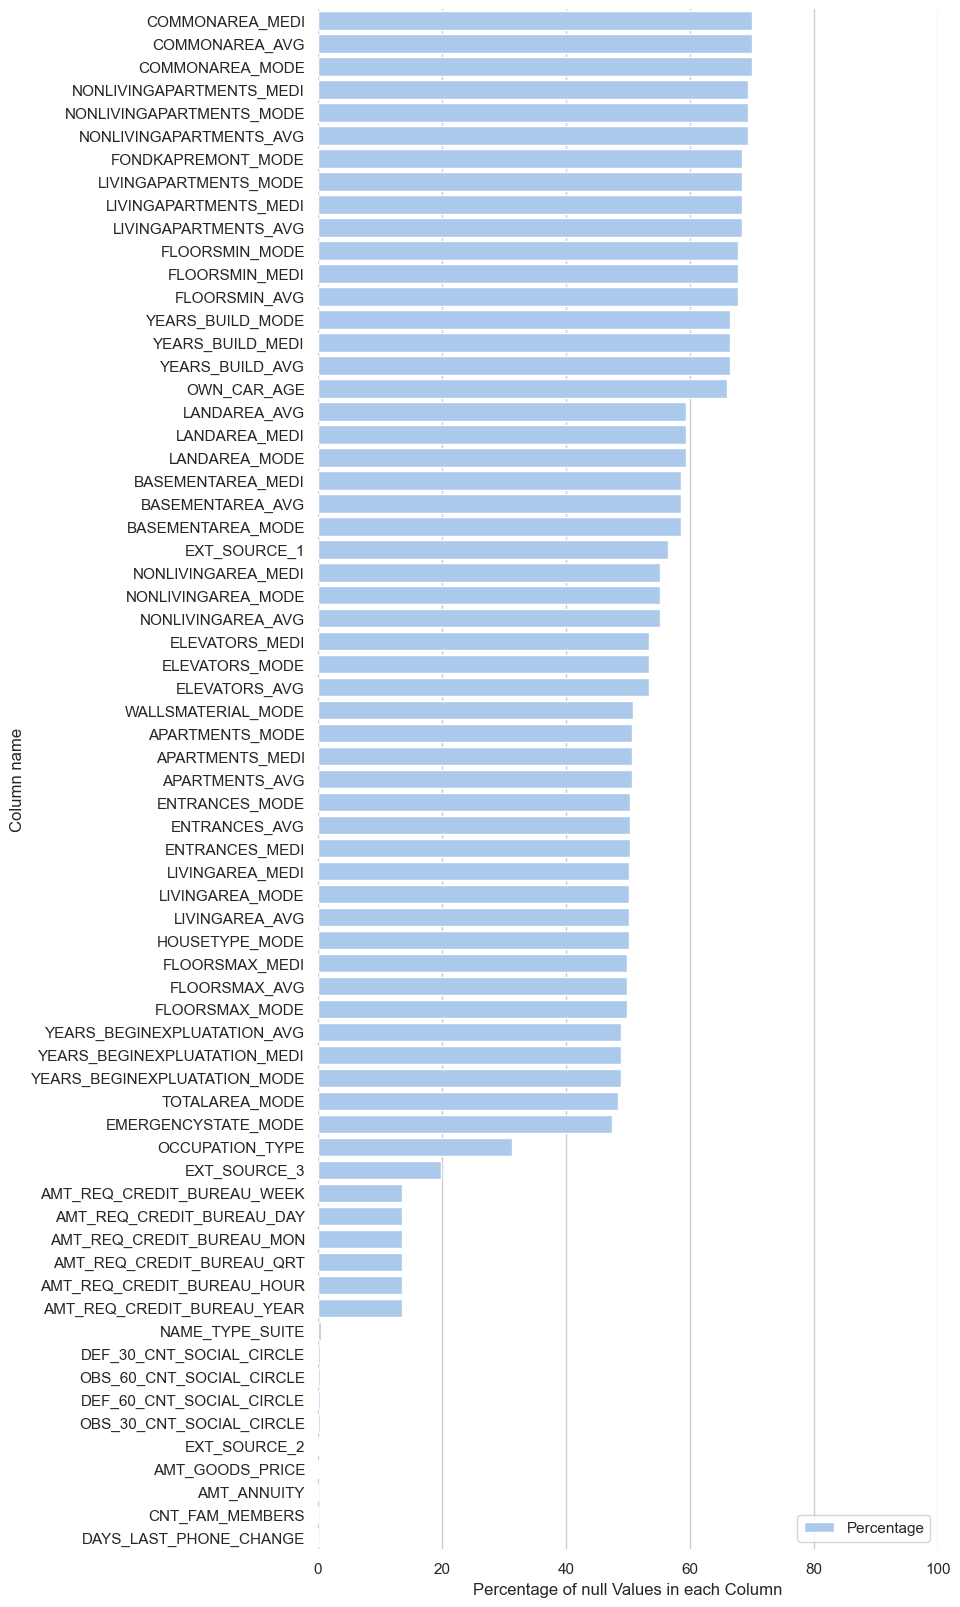

In [22]:
sns.set_theme(style="whitegrid")


f, ax = plt.subplots(figsize=(8,20))
sns.set_color_codes("pastel")

sns.barplot(y=mis_val_table.index.values, x=mis_val_table['% of Total Values'].values, label="Percentage", color="b")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 100), ylabel="Column name",
       xlabel="Percentage of null Values in each Column")
sns.despine(left=True, bottom=True)

## Missing Data

<AxesSubplot: >

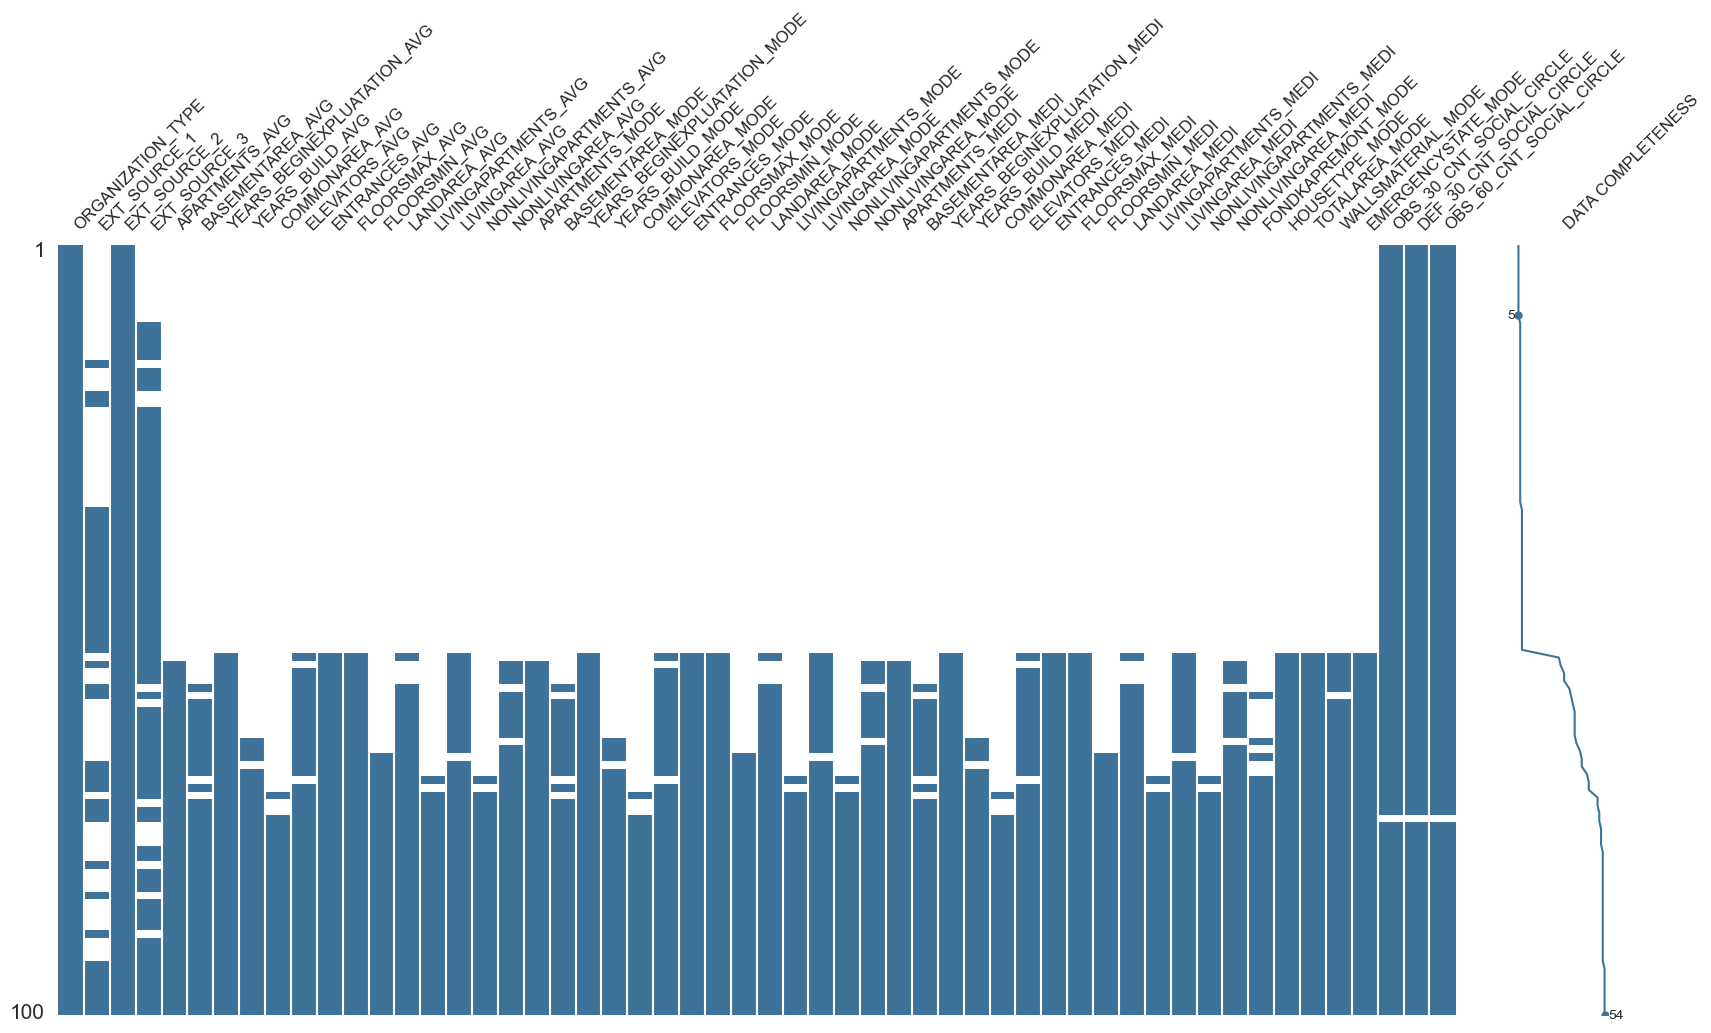

In [23]:
import missingno as msno

msno.matrix(df_train.iloc[0:100, 40:94], sparkline=True, figsize=(20,10), sort='ascending', fontsize=12, labels=True, color=(0.25, 0.45, 0.6))

In [24]:
df_train['incomplete'] = 1
df_train.loc[df_train.isnull().sum(axis=1) < 35, 'incomplete'] = 0

mean_c = np.mean(df_train.loc[df_train['incomplete'] == 0, 'TARGET'].values)
mean_i = np.mean(df_train.loc[df_train['incomplete'] == 1, 'TARGET'].values)
print('default ratio for more complete: {:.1%} \ndefault ratio for less complete: {:.1%}'.format(mean_c, mean_i))

default ratio for more complete: 6.9% 
default ratio for less complete: 9.2%


In [25]:
from scipy.stats import chi2_contingency

props = pd.crosstab(df_train.incomplete, df_train.TARGET)
c = chi2_contingency(props, lambda_="log-likelihood")
print(props, "\n p-value= ", c[1])

TARGET           0      1
incomplete               
0           142035  10606
1           140651  14219 
 p-value=  1.141230219527906e-114


## **Split to Numerical and Categorical Features**

In [26]:
def feature_type_split(data):
    cat_list = []
    dis_num_list = []
    num_list = []
    for i in data.columns.tolist():
        if data[i].dtype == 'object':
            cat_list.append(i)
        elif data[i].nunique() < 25:
            dis_num_list.append(i)
        else:
            num_list.append(i)
    return cat_list, dis_num_list, num_list

cat_list, dis_num_list, num_list = feature_type_split(df_train) 

# num_list= features numeriques continues

# cat_list= features categoriques

# dis_num_list=features numeriques discretes

In [27]:
df_c_numeric = df_train[num_list]
df_categorical = df_train[cat_list]
df_d_numeric = df_train[dis_num_list]

print("num_list",len(num_list))
print("cat_list",len(cat_list))
print("dis_num_list",len(dis_num_list))



num_list 61
cat_list 16
dis_num_list 46


# df_c_numeric= df features numeriques continues

In [28]:
df_c_numeric.head()

SK_ID_CURR  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0      100002          202500.0    406597.5      24700.5         351000.0   
1      100003          270000.0   1293502.5      35698.5        1129500.0   
2      100004           67500.0    135000.0       6750.0         135000.0   
3      100006          135000.0    312682.5      29686.5         297000.0   
4      100007          121500.0    513000.0      21865.5         513000.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  ...  LANDAREA_MEDI  LIVINGAPARTMENTS_MEDI  \
0            -2120  ...         0.0375                 0.0205   
1             -291  ...         0.0132                 0.0787   
2            -2531  ...            NaN                    NaN   
3            -2437  ...            NaN                    NaN   
4            -3458  ...            NaN                    NaN   

   LIVINGAREA_MEDI  NONLIVINGAPARTMENTS_MEDI  NONLIVINGAREA_MEDI  \
0           0.0193                    0.0000                0.00   
1           0.0558                    0.0039                0.01   
2              NaN                       NaN                 NaN   
3              NaN                       NaN                 NaN   
4              NaN                       NaN                 NaN   

   TOTALAREA_MODE  OBS_30_CNT_SOCIAL_CIRCLE  OBS_60_CNT_SOCIAL_CIRCLE  \
0          0.0149                       2.0                       2.0   
1          0.0714                       1.0                       1.0   
2             NaN                       0.0                       0.0   
3             NaN                       2.0                       2.0   
4             NaN                       0.0                       0.0   

   DAYS_LAST_PHONE_CHANGE  AMT_REQ_CREDIT_BUREAU_YEAR  
0                 -1134.0                         1.0  
1                  -828.0                         0.0  
2                  -815.0                         0.0  
3                  -617.0                         NaN  
4                 -1106.0                         0.0  

[5 rows x 61 columns]

# df_categorical= df features categoriques

In [29]:
df_categorical.head()

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY NAME_TYPE_SUITE  \
0         Cash loans           M            N               Y   Unaccompanied   
1         Cash loans           F            N               N          Family   
2    Revolving loans           M            Y               Y   Unaccompanied   
3         Cash loans           F            N               Y   Unaccompanied   
4         Cash loans           M            N               Y   Unaccompanied   

  NAME_INCOME_TYPE            NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0          Working  Secondary / secondary special  Single / not married   
1    State servant               Higher education               Married   
2          Working  Secondary / secondary special  Single / not married   
3          Working  Secondary / secondary special        Civil marriage   
4          Working  Secondary / secondary special  Single / not married   

   NAME_HOUSING_TYPE OCCUPATION_TYPE WEEKDAY_APPR_PROCESS_START  \
0  House / apartment        Laborers                  WEDNESDAY   
1  House / apartment      Core staff                     MONDAY   
2  House / apartment        Laborers                     MONDAY   
3  House / apartment        Laborers                  WEDNESDAY   
4  House / apartment      Core staff                   THURSDAY   

        ORGANIZATION_TYPE FONDKAPREMONT_MODE  HOUSETYPE_MODE  \
0  Business Entity Type 3   reg oper account  block of flats   
1                  School   reg oper account  block of flats   
2              Government                NaN             NaN   
3  Business Entity Type 3                NaN             NaN   
4                Religion                NaN             NaN   

  WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  
0       Stone, brick                  No  
1              Block                  No  
2                NaN                 NaN  
3                NaN                 NaN  
4                NaN                 NaN

# df_d_numeric= df features numeriques discretes

In [30]:
df_d_numeric.head()

TARGET  CNT_CHILDREN  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0       1             0           1               1                0   
1       0             0           1               1                0   
2       0             0           1               1                1   
3       0             0           1               1                0   
4       0             0           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0              1.0   
1                 1           1           0              2.0   
2                 1           1           0              1.0   
3                 1           0           0              2.0   
4                 1           0           0              1.0   

   REGION_RATING_CLIENT  ...  FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  \
0                     2  ...                 0                 0   
1                     1  ...                 0                 0   
2                     2  ...                 0                 0   
3                     2  ...                 0                 0   
4                     2  ...                 0                 0   

   FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  AMT_REQ_CREDIT_BUREAU_HOUR  \
0                 0                 0                         0.0   
1                 0                 0                         0.0   
2                 0                 0                         0.0   
3                 0                 0                         NaN   
4                 0                 0                         0.0   

   AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        NaN                         NaN   
4                        0.0                         0.0   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  incomplete  
0                        0.0                        0.0           0  
1                        0.0                        0.0           0  
2                        0.0                        0.0           1  
3                        NaN                        NaN           1  
4                        0.0                        0.0           1  

[5 rows x 46 columns]

# valeurs manquantes imputees par median (continues) ou most frequent (discretes ou categorielles)

In [31]:
from sklearn.impute import SimpleImputer
import time


#categoriques
df_train[cat_list] = SimpleImputer(strategy='most_frequent').fit_transform(df_train[cat_list])

#discrete
df_train[dis_num_list] = SimpleImputer(strategy='most_frequent').fit_transform(df_train[dis_num_list])

#continues

df_train[num_list] = SimpleImputer(strategy='median').fit_transform(df_train[num_list])


In [32]:
df_train

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0         100002.0     1.0         Cash loans           M            N   
1         100003.0     0.0         Cash loans           F            N   
2         100004.0     0.0    Revolving loans           M            Y   
3         100006.0     0.0         Cash loans           F            N   
4         100007.0     0.0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506    456251.0     0.0         Cash loans           M            N   
307507    456252.0     0.0         Cash loans           F            N   
307508    456253.0     0.0         Cash loans           F            N   
307509    456254.0     1.0         Cash loans           F            N   
307510    456255.0     0.0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y           0.0          202500.0    406597.5   
1                    N           0.0          270000.0   1293502.5   
2                    Y           0.0           67500.0    135000.0   
3                    Y           0.0          135000.0    312682.5   
4                    Y           0.0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N           0.0          157500.0    254700.0   
307507               Y           0.0           72000.0    269550.0   
307508               Y           0.0          153000.0    677664.0   
307509               Y           0.0          171000.0    370107.0   
307510               N           0.0          157500.0    675000.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0           24700.5  ...               0.0              0.0              0.0   
1           35698.5  ...               0.0              0.0              0.0   
2            6750.0  ...               0.0              0.0              0.0   
3           29686.5  ...               0.0              0.0              0.0   
4           21865.5  ...               0.0              0.0              0.0   
...             ...  ...               ...              ...              ...   
307506      27558.0  ...               0.0              0.0              0.0   
307507      12001.5  ...               0.0              0.0              0.0   
307508      29979.0  ...               0.0              0.0              0.0   
307509      20205.0  ...               0.0              0.0              0.0   
307510      49117.5  ...               0.0              0.0              0.0   

       AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                             0.0                       0.0   
1                             0.0                       0.0   
2                             0.0                       0.0   
3                             0.0                       0.0   
4                             0.0                       0.0   
...                           ...                       ...   
307506                        0.0                       0.0   
307507                        0.0                       0.0   
307508                        1.0                       0.0   
307509                        0.0                       0.0   
307510                        0.0                       0.0   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                             0.0                        0.0   
1                             0.0                        0.0   
2                             0.0                        0.0   
3                             0.0                        0.0   
4                             0.0                        0.0   
...                           ...                        ...   
307506                        0.0                        0.0   
307507                        0.0               

In [33]:
df_train.dropna()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0         100002.0     1.0         Cash loans           M            N   
1         100003.0     0.0         Cash loans           F            N   
2         100004.0     0.0    Revolving loans           M            Y   
3         100006.0     0.0         Cash loans           F            N   
4         100007.0     0.0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506    456251.0     0.0         Cash loans           M            N   
307507    456252.0     0.0         Cash loans           F            N   
307508    456253.0     0.0         Cash loans           F            N   
307509    456254.0     1.0         Cash loans           F            N   
307510    456255.0     0.0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y           0.0          202500.0    406597.5   
1                    N           0.0          270000.0   1293502.5   
2                    Y           0.0           67500.0    135000.0   
3                    Y           0.0          135000.0    312682.5   
4                    Y           0.0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N           0.0          157500.0    254700.0   
307507               Y           0.0           72000.0    269550.0   
307508               Y           0.0          153000.0    677664.0   
307509               Y           0.0          171000.0    370107.0   
307510               N           0.0          157500.0    675000.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0           24700.5  ...               0.0              0.0              0.0   
1           35698.5  ...               0.0              0.0              0.0   
2            6750.0  ...               0.0              0.0              0.0   
3           29686.5  ...               0.0              0.0              0.0   
4           21865.5  ...               0.0              0.0              0.0   
...             ...  ...               ...              ...              ...   
307506      27558.0  ...               0.0              0.0              0.0   
307507      12001.5  ...               0.0              0.0              0.0   
307508      29979.0  ...               0.0              0.0              0.0   
307509      20205.0  ...               0.0              0.0              0.0   
307510      49117.5  ...               0.0              0.0              0.0   

       AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                             0.0                       0.0   
1                             0.0                       0.0   
2                             0.0                       0.0   
3                             0.0                       0.0   
4                             0.0                       0.0   
...                           ...                       ...   
307506                        0.0                       0.0   
307507                        0.0                       0.0   
307508                        1.0                       0.0   
307509                        0.0                       0.0   
307510                        0.0                       0.0   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                             0.0                        0.0   
1                             0.0                        0.0   
2                             0.0                        0.0   
3                             0.0                        0.0   
4                             0.0                        0.0   
...                           ...                        ...   
307506                        0.0                        0.0   
307507                        0.0               

#  Outliers pour features numeriques continues

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose l

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

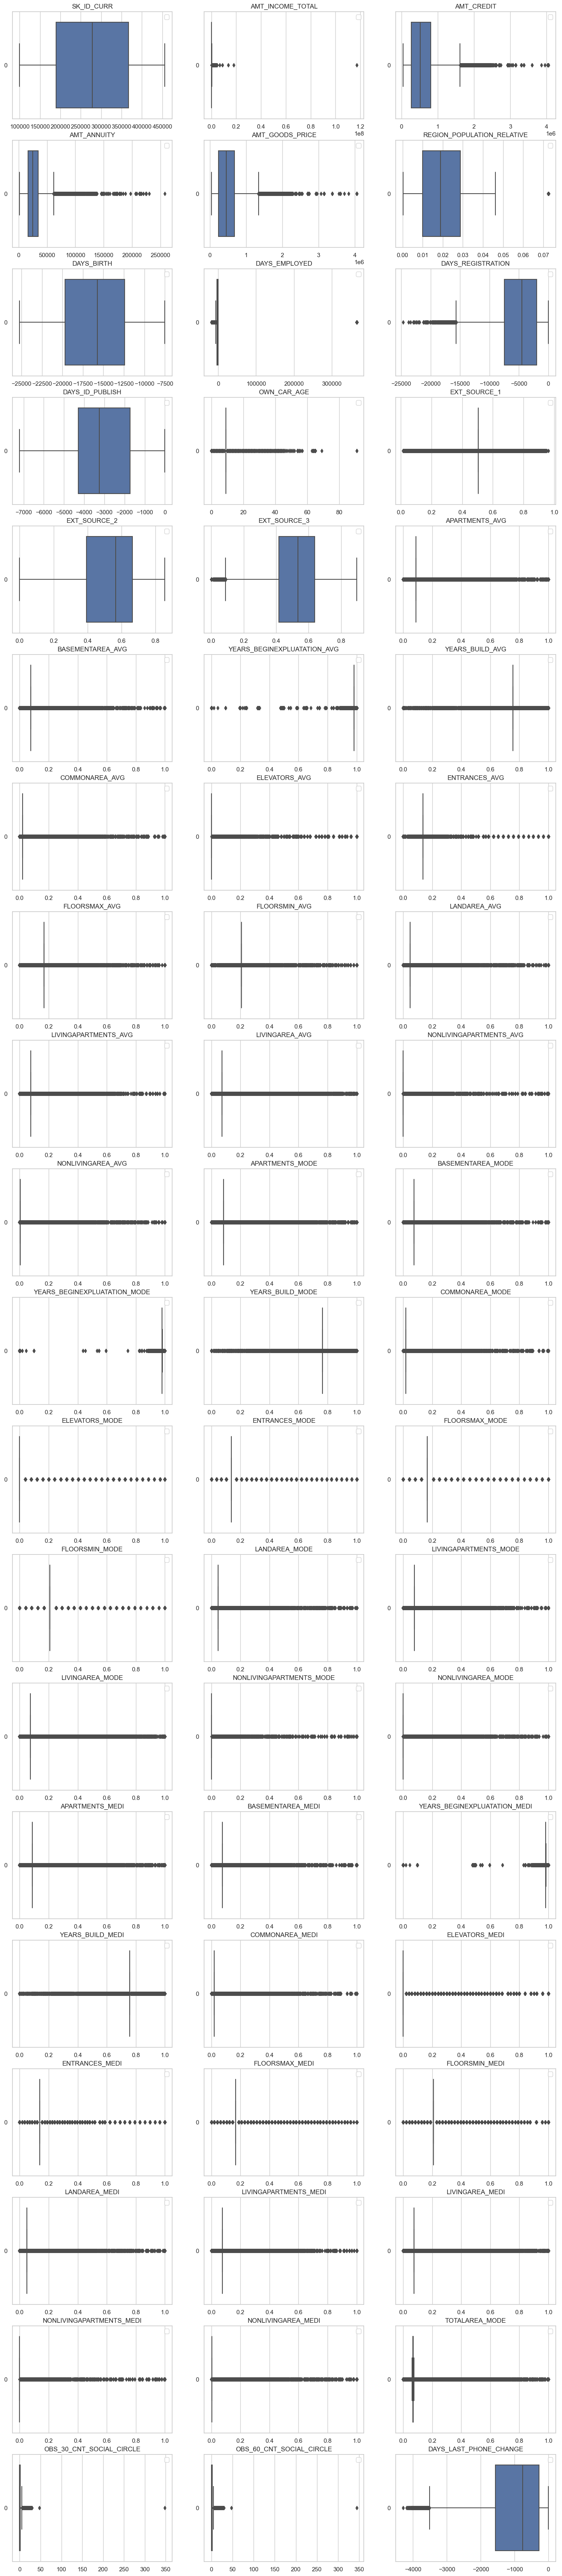

In [34]:
sns.set_theme(style="whitegrid")
gs = gridspec.GridSpec(20, 3)

f, ax = plt.subplots(figsize=(18,85))

columns =df_train[num_list].columns.values[:60]
c = 0
for i in range (20):
    for j in range (3):
        ax = plt.subplot(gs[i, j])
        sns.boxplot(data=df_train[num_list].iloc[:,c], orient="h")
        ax.set_title(columns[c])
        ax.legend()
        c+=1


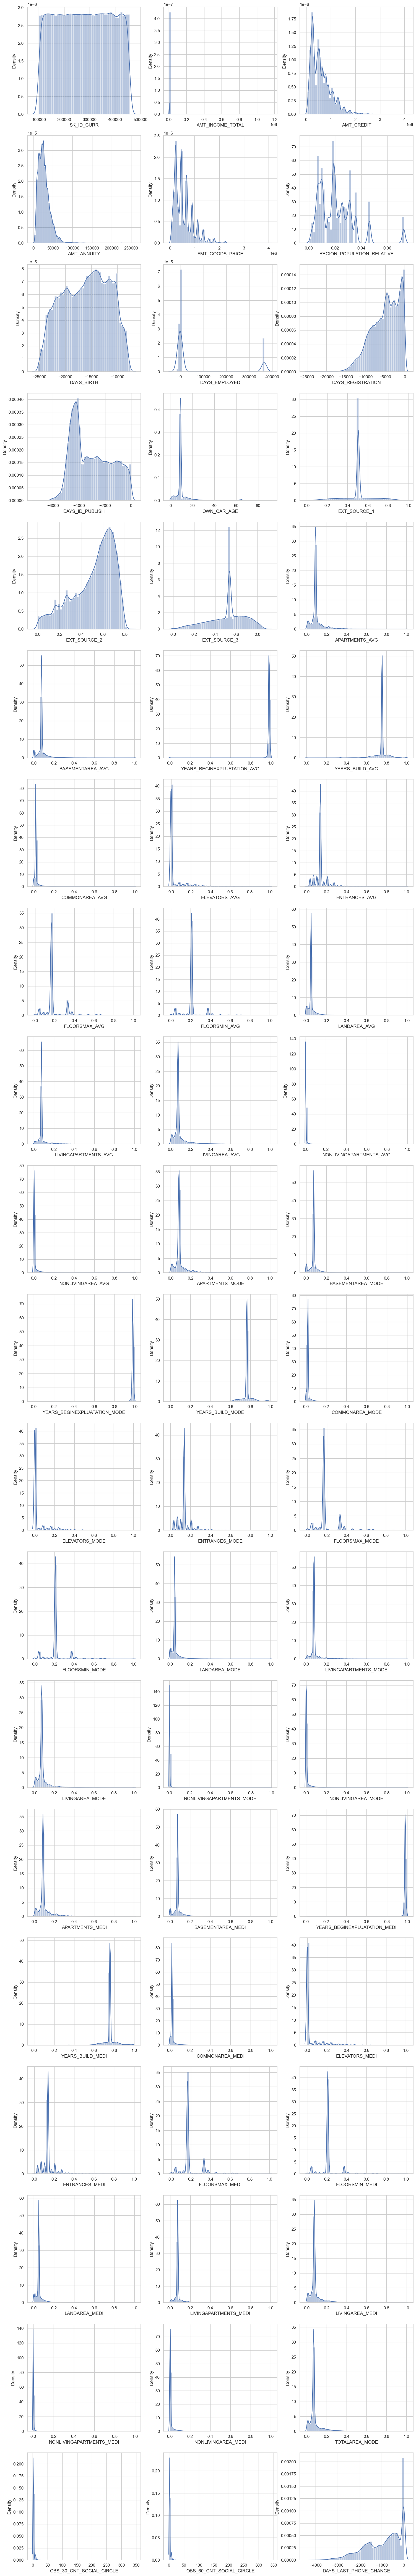

In [35]:
import warnings
warnings.filterwarnings('ignore')



sns.set_theme(style="whitegrid")
gs = gridspec.GridSpec(20, 3)

f, ax = plt.subplots(figsize=(18,120))

columns =df_train[num_list].columns.values[:60]

c = 0
for i in range (20):
    for j in range (3):
        ax = plt.subplot(gs[i, j])
        sns.distplot(df_train[num_list].iloc[:,c])
        c+=1

In [36]:
# suprimer outliers par interquartile exemple sur 'DAYS_REGISTRATION'
df = df_train[num_list]

#intterquartile
percentile25 = df['DAYS_REGISTRATION'].quantile(0.25)
percentile75 = df['DAYS_REGISTRATION'].quantile(0.75)

IQR = percentile75 - percentile25

#sup et inf
upper_limit = percentile75 + 1.5 * IQR
lower_limit = percentile25 - 1.5 * IQR

#Outliers

df[df['DAYS_REGISTRATION'] > upper_limit]
df[df['DAYS_REGISTRATION'] < lower_limit]

#Trimming

new_df = df.loc[(df['DAYS_REGISTRATION'] < upper_limit) & (df['DAYS_REGISTRATION'] > lower_limit)]
new_df.shape

#Capping

new_df_cap = df_train[num_list].copy()

new_df_cap["DAYS_REGISTRATION"] = np.where(new_df_cap['DAYS_REGISTRATION'] < lower_limit,lower_limit
                                          ,np.where(new_df_cap['DAYS_REGISTRATION'] > upper_limit,upper_limit,
                                                   new_df_cap["DAYS_REGISTRATION"] )
                                          )

#Compare the plots after trimming
new_df_cap.shape

(307511, 61)

#### apres et avant ourliers removal, exemples

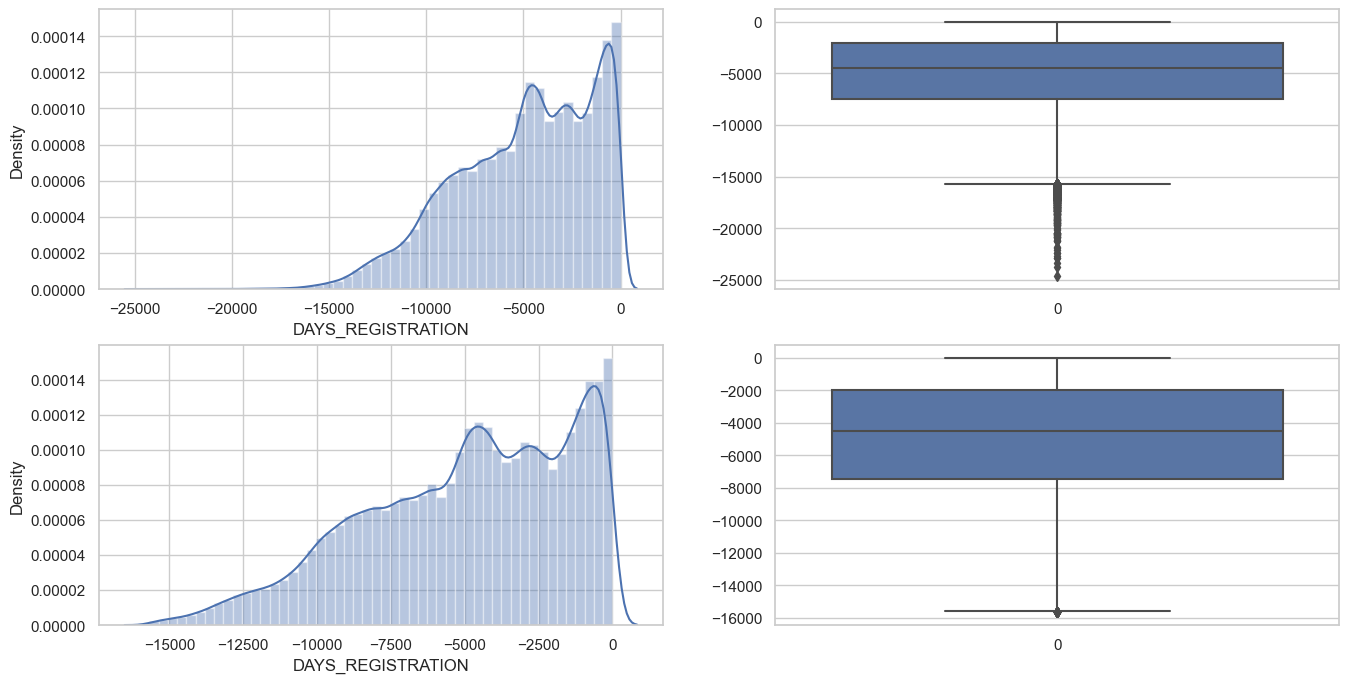

In [37]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(df_train[num_list]['DAYS_REGISTRATION'])
plt.subplot(2,2,2)
sns.boxplot(df_train[num_list]['DAYS_REGISTRATION'])
plt.subplot(2,2,3)
sns.distplot(new_df['DAYS_REGISTRATION'])
plt.subplot(2,2,4)
sns.boxplot(new_df['DAYS_REGISTRATION'])
plt.show()

# remove outliers pour features numeriques continues

In [38]:
# Remove outliers
def remov_outliers(df, feature):

    #Finding the IQR
    percentile25 = df[str(feature)].quantile(0.25)
    percentile75 = df[str(feature)].quantile(0.75)

    IQR = percentile75 - percentile25

    #Finding upper and lower limit
    upper_limit = percentile75 + 1.5 * IQR
    lower_limit = percentile25 - 1.5 * IQR

    #Finding Outliers

    df[df[feature] > upper_limit]
    df[df[feature] < lower_limit]

    #Trimming

    new_df = df.loc[(df[feature] < upper_limit) & (df[feature] > lower_limit)]
    new_df.shape

    #Capping

    new_df_cap = df.copy()

    new_df_cap[feature] = np.where(new_df_cap[feature] < lower_limit,lower_limit
                                              ,np.where(new_df_cap[feature] > upper_limit,upper_limit,
                                                       new_df_cap[feature] )
                                              )

    return new_df_cap

In [39]:
# Remove outliers for all features
df_imputed_new = df_c_numeric.copy()
# df_imputed_new = df_imputed_new.drop(columns=['SK_ID_CURR', 'TARGET'],axis = 1)

columns = df_imputed_new.columns.values

for i in columns:
    df_imputed_new = remov_outliers(df_imputed_new, i)




# visualize the feature distribution after capping outliers

In [40]:
df_imputed_new

SK_ID_CURR  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0         100002.0          202500.0    406597.5      24700.5   
1         100003.0          270000.0   1293502.5      35698.5   
2         100004.0           67500.0    135000.0       6750.0   
3         100006.0          135000.0    312682.5      29686.5   
4         100007.0          121500.0    513000.0      21865.5   
...            ...               ...         ...          ...   
307506    456251.0          157500.0    254700.0      27558.0   
307507    456252.0           72000.0    269550.0      12001.5   
307508    456253.0          153000.0    677664.0      29979.0   
307509    456254.0          171000.0    370107.0      20205.0   
307510    456255.0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0              351000.0                    0.018801     -9461.0   
1             1129500.0                    0.003541    -16765.0   
2              135000.0                    0.010032    -19046.0   
3              297000.0                    0.008019    -19005.0   
4              513000.0                    0.028663    -19932.0   
...                 ...                         ...         ...   
307506         225000.0                    0.032561     -9327.0   
307507         225000.0                    0.025164    -20775.0   
307508         585000.0                    0.005002    -14966.0   
307509         319500.0                    0.005313    -11961.0   
307510         675000.0                    0.046220    -16856.0   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  ...  LANDAREA_MEDI  \
0              -637.0            -3648.0          -2120.0  ...         0.0375   
1             -1188.0            -1186.0           -291.0  ...         0.0132   
2              -225.0            -4260.0          -2531.0  ...            NaN   
3             -3039.0            -9833.0          -2437.0  ...            NaN   
4             -3038.0            -4311.0          -3458.0  ...            NaN   
...               ...                ...              ...  ...            ...   
307506         -236.0            -8456.0          -1982.0  ...         0.0605   
307507         3417.5            -4388.0          -4090.0  ...         0.0589   
307508        -6466.5            -6737.0          -5150.0  ...            NaN   
307509        -4786.0            -2562.0           -931.0  ...            NaN   
307510        -1262.0            -5128.0           -410.0  ...            NaN   

        LIVINGAPARTMENTS_MEDI  LIVINGAREA_MEDI  NONLIVINGAPARTMENTS_MEDI  \
0                      0.0205           0.0193                   0.00000   
1                      0.0787           0.0558                   0.00390   
2                         NaN              NaN                       NaN   
3                         NaN              NaN                       NaN   
4                         NaN              NaN                       NaN   
...                       ...              ...                       ...   
307506                 0.1509           0.2001                   0.00975   
307507                 0.0205           0.0261                   0.00000   
307508                 0.0855           0.2572                   0.00000   
307509                    NaN           0.0062                       NaN   
307510                    NaN           0.0805                       NaN   

        NONLIVINGAREA_MEDI  TOTALAREA_MODE  OBS_30_CNT_SOCIAL_CIRCLE  \
0                   0.0000          0.0149                       2.0   
1                   0.0100          0.0714                       1.0   
2                      NaN             NaN                       0.0   
3                      NaN             NaN                       2.0   
4                      NaN             NaN                       0.0   
...                    ...             ...                       ...   
307506              0.0665      

In [41]:
df_c_numeric.shape

(307511, 61)

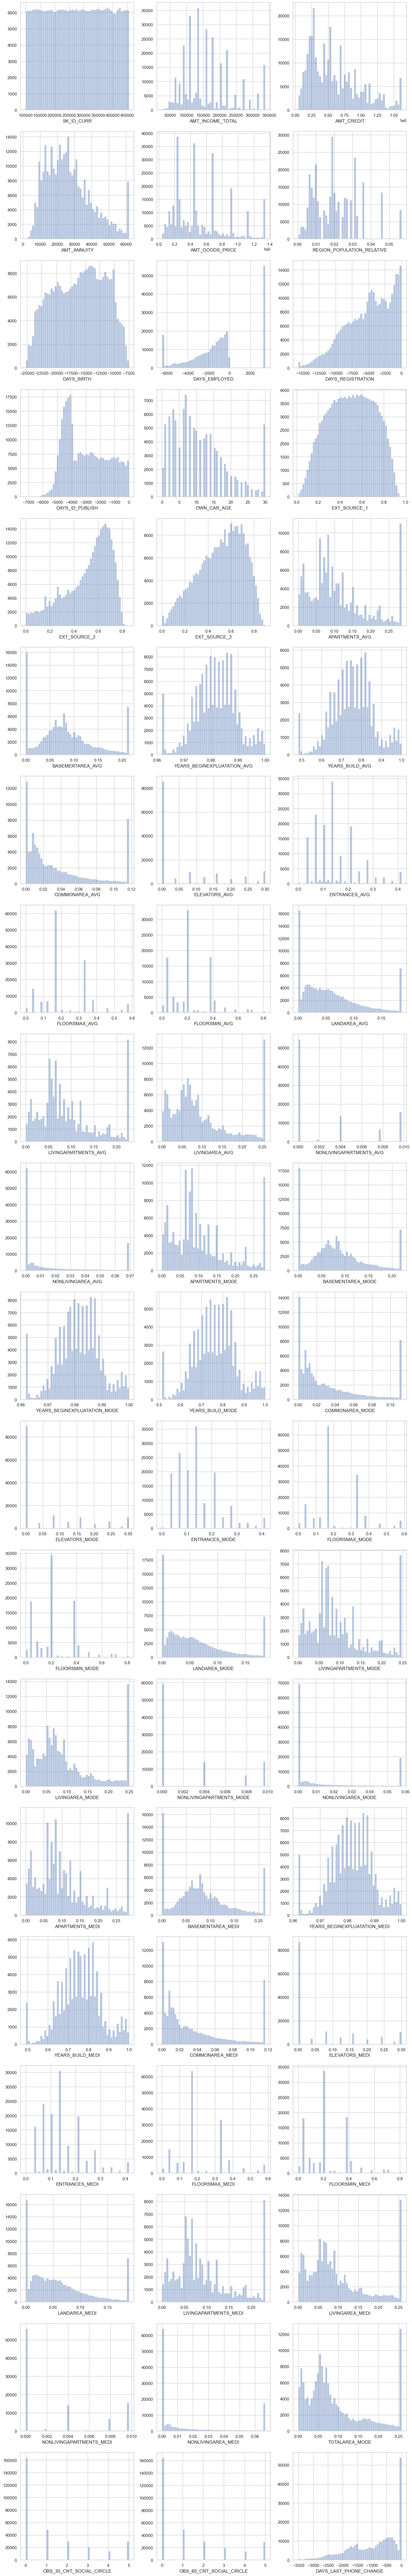

In [42]:
#visualize the feature distribution after capping outliers
import warnings
warnings.filterwarnings('ignore')



sns.set_theme(style="whitegrid")
gs = gridspec.GridSpec(20, 3)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(18,120))

columns = df_c_numeric.columns.values[:60]
c = 0
for i in range (20):
    for j in range (3):
        ax = plt.subplot(gs[i, j])
        sns.distplot(df_imputed_new.iloc[:,c],kde=False)

        c+=1

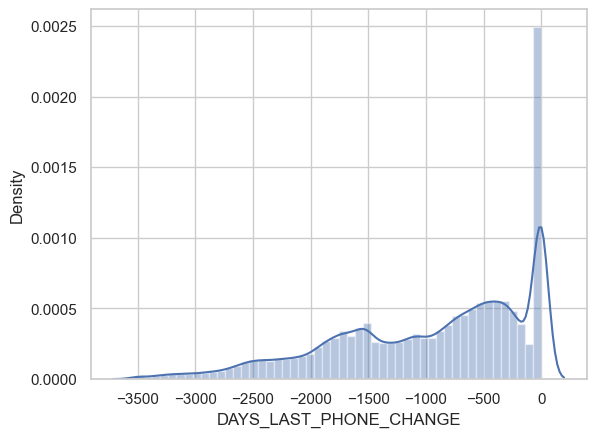

In [43]:
sns.distplot(df_imputed_new["DAYS_LAST_PHONE_CHANGE"])
plt.show()

# df_imputed_new= df numeriques continues et discretes

In [44]:
#Concat again the Dis Numerical Features
df_imputed_new = pd.concat([df_imputed_new,df_d_numeric ],axis = 1)

# Data Transformations: Robust scaler applied to continuous numerical features


In [45]:
len(num_list)

61

In [46]:
from sklearn.preprocessing import RobustScaler

transformer = RobustScaler().fit(df_imputed_new[num_list])
df_imputed_new[num_list] = transformer.transform(df_imputed_new[num_list])

# **statistical analysis for numerical features**

In [47]:
df_imputed_new.head()

SK_ID_CURR  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0   -1.001140             0.615   -0.198521    -0.011205        -0.224490   
1   -1.001135             1.365    1.448012     0.597361         1.540816   
2   -1.001129            -0.885   -0.702740    -1.004482        -0.714286   
3   -1.001118            -0.135   -0.372874     0.264691        -0.346939   
4   -1.001112            -0.285   -0.000986    -0.168078         0.142857   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                   -0.002626    0.865181       0.233104           0.156504   
1                   -0.820550   -0.139634       0.010117           0.606637   
2                   -0.472638   -0.453432       0.399838           0.044611   
3                   -0.580533   -0.447792      -0.738972          -0.974312   
4                    0.525969   -0.575320      -0.738567           0.035287   

   DAYS_ID_PUBLISH  ...  FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  \
0         0.439705  ...                 0                 0                 0   
1         1.148895  ...                 0                 0                 0   
2         0.280341  ...                 0                 0                 0   
3         0.316789  ...                 0                 0                 0   
4        -0.079100  ...                 0                 0                 0   

   FLAG_DOCUMENT_21  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                 0                         0.0                        0.0   
1                 0                         0.0                        0.0   
2                 0                         0.0                        0.0   
3                 0                         NaN                        NaN   
4                 0                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  incomplete  
0                        0.0           0  
1                        0.0           0  
2                        0.0           1  
3                        NaN           1  
4                        0.0           1  

[5 rows x 107 columns]

In [48]:
import scipy.stats


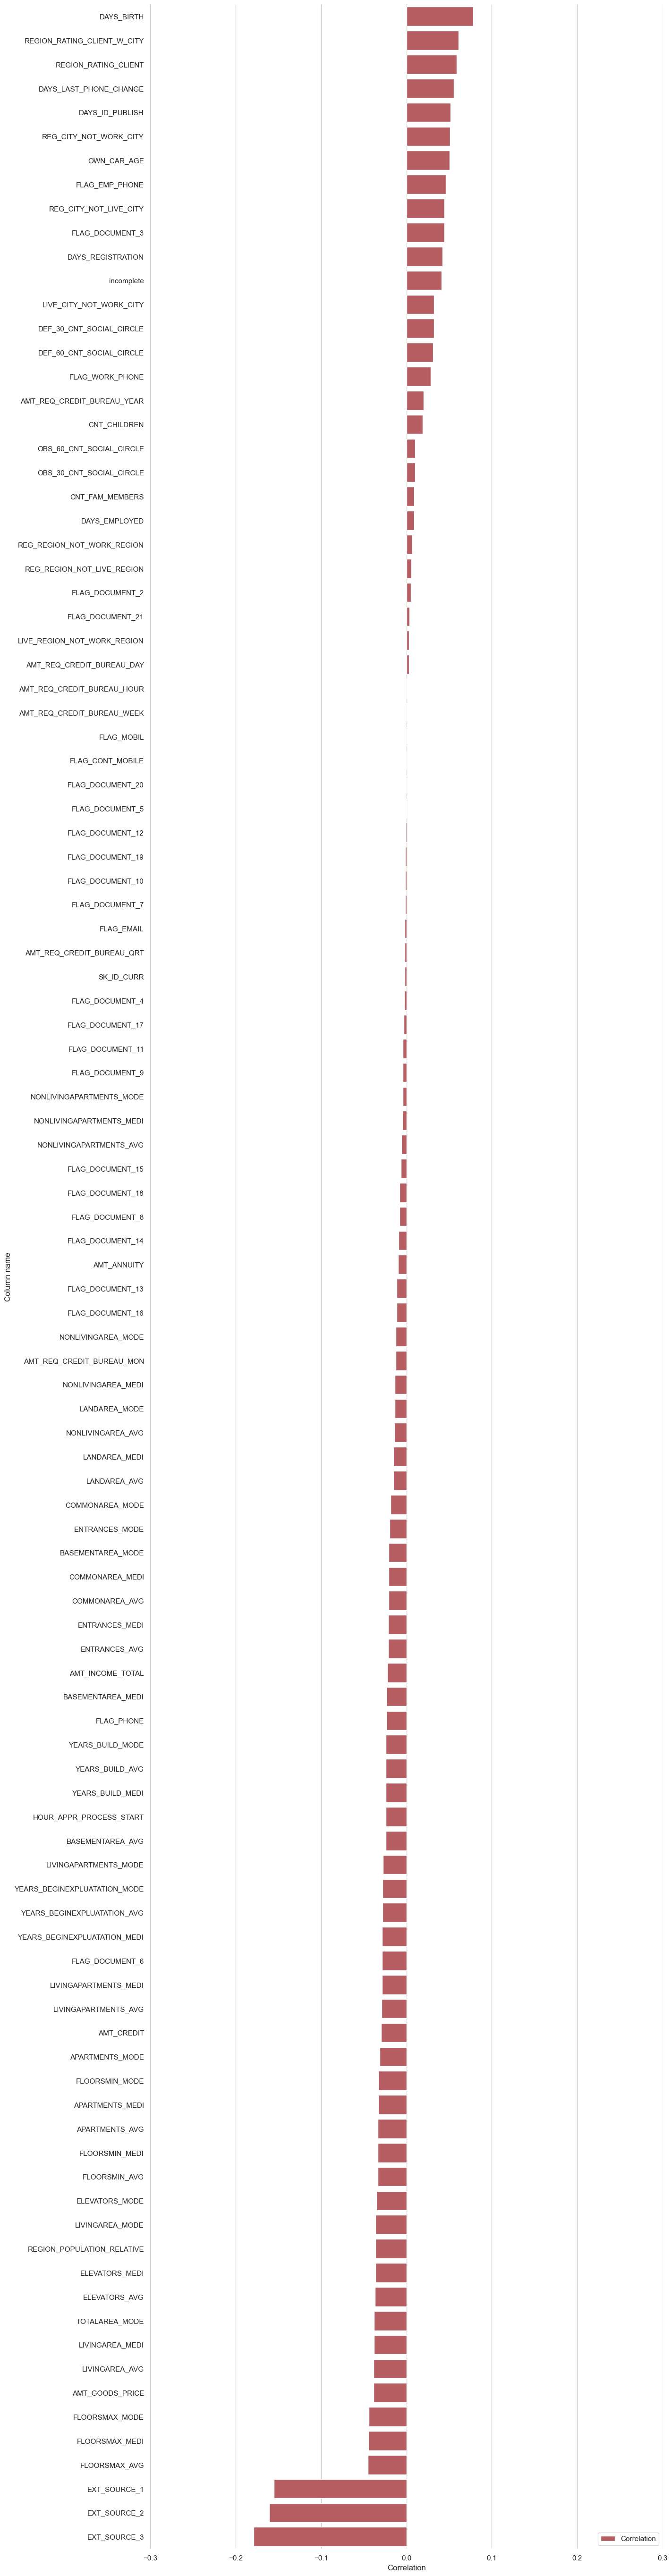

In [49]:
plt.figure(figsize=(14,70))
y_corr = df_imputed_new.corr().loc["TARGET"].sort_values(ascending=False).drop("TARGET",axis = 0).dropna()

ax = sns.barplot(y=y_corr.index.values, x=y_corr.values,
            label="Correlation", color="r")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(-0.3, 0.3), ylabel="Column name",
       xlabel="Correlation")
sns.despine(left=True, bottom=True)

#**['OWN_CAR_AGE', 'DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE',
'DAYS_ID_PUBLISH', 'FLAG_DOCUMENT_3', 'DAYS_REGISTRATION',
>        'NONLIVINGAPARTMENTS_MODE']  &  ['REGION_POPULATION_RELATIVE', 'AMT_GOODS_PRICE', 'EXT_SOURCE_2',
>        'EXT_SOURCE_3', 'EXT_SOURCE_1']**

In [50]:
y_corr = df_imputed_new.corr().loc["TARGET"].sort_values(ascending=False).drop("TARGET",axis = 0).dropna()


In [51]:
lst = list(df_imputed_new.columns.values[:80])

### Testing the assumptions

In [52]:
# import the data
from scipy import stats

def test(df):
    columns = df.columns.values

    test_df = pd.DataFrame(columns, columns= ['Column name'])
    test_df["normality"] = 0
    test_df["homogeneity"] = 0

    Repay = df[df['TARGET'] == 0]
    No_Repay = df[df['TARGET'] == 1]

    for col in columns:

        # homogeneity
        s, p_value = stats.levene(Repay[str(col)].values.flatten(), No_Repay[str(col)].values.flatten())
        if p_value < 0.05:
            test_df.loc[test_df["Column name"] == str(col), "homogeneity"] = 1


        # Shapiro-Wilk test normalite
        s, p_value = stats.shapiro(Repay[str(col)].values.flatten())
        s2, p_value2 = stats.shapiro(No_Repay[str(col)].values.flatten())

        if p_value < 0.05 and p_value2 <0.05:
            test_df.loc[test_df["Column name"] == str(col), "normality"] = 1
        
    return test_df



In [53]:
df_imputed_new.shape

(307511, 107)

In [54]:
test_df = test(df_imputed_new)

In [55]:
test_df

Column name  normality  homogeneity
0                    SK_ID_CURR          1            0
1              AMT_INCOME_TOTAL          1            1
2                    AMT_CREDIT          1            1
3                   AMT_ANNUITY          0            0
4               AMT_GOODS_PRICE          0            0
..                          ...        ...          ...
102   AMT_REQ_CREDIT_BUREAU_DAY          0            0
103  AMT_REQ_CREDIT_BUREAU_WEEK          0            0
104   AMT_REQ_CREDIT_BUREAU_MON          0            0
105   AMT_REQ_CREDIT_BUREAU_QRT          0            0
106                  incomplete          1            1

[107 rows x 3 columns]

In [56]:
#Features satisfaisant l'hypothese
acc_features = test_df.loc[(test_df["normality"] == 1) &(test_df["homogeneity"] == 1)]

In [57]:
acc_features

Column name  normality  homogeneity
1               AMT_INCOME_TOTAL          1            1
2                     AMT_CREDIT          1            1
5     REGION_POPULATION_RELATIVE          1            1
6                     DAYS_BIRTH          1            1
7                  DAYS_EMPLOYED          1            1
8              DAYS_REGISTRATION          1            1
9                DAYS_ID_PUBLISH          1            1
62                  CNT_CHILDREN          1            1
64                FLAG_EMP_PHONE          1            1
65               FLAG_WORK_PHONE          1            1
67                    FLAG_PHONE          1            1
70          REGION_RATING_CLIENT          1            1
71   REGION_RATING_CLIENT_W_CITY          1            1
73    REG_REGION_NOT_LIVE_REGION          1            1
74    REG_REGION_NOT_WORK_REGION          1            1
76        REG_CITY_NOT_LIVE_CITY          1            1
77        REG_CITY_NOT_WORK_CITY          1            1
78       LIVE_CITY_NOT_WORK_CITY          1            1
81               FLAG_DOCUMENT_2          1            1
82               FLAG_DOCUMENT_3          1            1
85               FLAG_DOCUMENT_6          1            1
87               FLAG_DOCUMENT_8          1            1
88               FLAG_DOCUMENT_9          1            1
90              FLAG_DOCUMENT_11          1            1
92              FLAG_DOCUMENT_13          1            1
93              FLAG_DOCUMENT_14          1            1
94              FLAG_DOCUMENT_15          1            1
95              FLAG_DOCUMENT_16          1            1
97              FLAG_DOCUMENT_18          1            1
100             FLAG_DOCUMENT_21          1            1
106                   incomplete          1            1

In [58]:
test_df.loc[(test_df["normality"] == 0) | (test_df["homogeneity"] == 0)]

Column name  normality  homogeneity
0                    SK_ID_CURR          1            0
3                   AMT_ANNUITY          0            0
4               AMT_GOODS_PRICE          0            0
10                  OWN_CAR_AGE          0            0
11                 EXT_SOURCE_1          0            0
..                          ...        ...          ...
101  AMT_REQ_CREDIT_BUREAU_HOUR          0            0
102   AMT_REQ_CREDIT_BUREAU_DAY          0            0
103  AMT_REQ_CREDIT_BUREAU_WEEK          0            0
104   AMT_REQ_CREDIT_BUREAU_MON          0            0
105   AMT_REQ_CREDIT_BUREAU_QRT          0            0

[76 rows x 3 columns]

## **T-test**

In [59]:
import scipy
def t_test(df,test_df):
    accept_null_hypo = []
    reject_null_hypo = []
    #select only Variables that satisfy the assumptions ( Normality and homogenous)
    columns = test_df.loc[(test_df["normality"] == 1) &(test_df["homogeneity"] == 1)]["Column name"].values

    Repay = df[(df['TARGET'] == 0)]
    No_Repay = df[(df['TARGET'] == 1)]

    for col in columns:

        #conduct the Independent t-test
        s, p_value = stats.ttest_ind(Repay[str(col)], No_Repay[str(col)])
        if p_value < 0.05:
            reject_null_hypo.append(col)
        else:
            accept_null_hypo.append(col)
            
    return accept_null_hypo,reject_null_hypo

In [60]:
accept_null_hypo, reject_null_hypo = t_test(df_imputed_new,test_df)

In [61]:
accept_null_hypo

[]

In [62]:
reject_null_hypo

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'CNT_CHILDREN',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_21',
 'incomplete']

### on prends les 50 features les plus correlees

In [63]:
X = df_imputed_new.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = df_imputed_new.TARGET
feature_name = X.columns.tolist()

In [64]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():

        cor = np.corrcoef(X[i].values.flatten(), y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-50:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [65]:
cor_support, cor_feature =cor_selector(X, y)

In [66]:
# feature not matched between Correlation analysis and T-test
not_matched = [i for i in cor_feature if  i not in reject_null_hypo ]
not_matched

['APARTMENTS_MODE',
 'LIVINGAPARTMENTS_AVG',
 'ENTRANCES_AVG',
 'LANDAREA_AVG',
 'FLOORSMIN_AVG',
 'FLOORSMAX_AVG',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_5',
 'FLAG_CONT_MOBILE',
 'FLAG_MOBIL',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_7',
 'FLAG_EMAIL',
 'FLAG_DOCUMENT_4',
 'LIVE_REGION_NOT_WORK_REGION',
 'FLAG_DOCUMENT_17',
 'HOUR_APPR_PROCESS_START']

In [67]:
# feature  matched between Correlation analysis and T-test
matched = [i for i in cor_feature if  i  in reject_null_hypo ]
matched

['FLAG_DOCUMENT_21',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_2',
 'REG_REGION_NOT_LIVE_REGION',
 'FLAG_DOCUMENT_15',
 'REG_REGION_NOT_WORK_REGION',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_8',
 'DAYS_EMPLOYED',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_16',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'FLAG_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_DOCUMENT_6',
 'AMT_CREDIT',
 'LIVE_CITY_NOT_WORK_CITY',
 'REGION_POPULATION_RELATIVE',
 'incomplete',
 'DAYS_REGISTRATION',
 'FLAG_DOCUMENT_3',
 'REG_CITY_NOT_LIVE_CITY',
 'FLAG_EMP_PHONE',
 'REG_CITY_NOT_WORK_CITY',
 'DAYS_ID_PUBLISH',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'DAYS_BIRTH']

In [68]:
# Generate the Dataframe of selected features

df_numerical = df_imputed_new[matched]

# df_numerical= df des features de df_imputed_new corellees

In [69]:
df_numerical

FLAG_DOCUMENT_21  FLAG_DOCUMENT_11  FLAG_DOCUMENT_9  FLAG_DOCUMENT_2  \
0                      0                 0                0                0   
1                      0                 0                0                0   
2                      0                 0                0                0   
3                      0                 0                0                0   
4                      0                 0                0                0   
...                  ...               ...              ...              ...   
307506                 0                 0                0                0   
307507                 0                 0                0                0   
307508                 0                 0                0                0   
307509                 0                 0                0                0   
307510                 0                 0                0                0   

        REG_REGION_NOT_LIVE_REGION  FLAG_DOCUMENT_15  \
0                                0                 0   
1                                0                 0   
2                                0                 0   
3                                0                 0   
4                                0                 0   
...                            ...               ...   
307506                           0                 0   
307507                           0                 0   
307508                           0                 0   
307509                           0                 0   
307510                           0                 0   

        REG_REGION_NOT_WORK_REGION  FLAG_DOCUMENT_18  FLAG_DOCUMENT_8  \
0                                0                 0                0   
1                                0                 0                0   
2                                0                 0                0   
3                                0                 0                0   
4                                0                 0                1   
...                            ...               ...              ...   
307506                           0                 0                1   
307507                           0                 0                0   
307508                           0                 0                0   
307509                           0                 0                0   
307510                           0                 0                0   

        DAYS_EMPLOYED  ...  incomplete  DAYS_REGISTRATION  FLAG_DOCUMENT_3  \
0            0.233104  ...           0           0.156504                1   
1            0.010117  ...           0           0.606637                1   
2            0.399838  ...           1           0.044611                0   
3           -0.738972  ...           1          -0.974312                1   
4           -0.738567  ...           1           0.035287                0   
...               ...  ...         ...                ...              ...   
307506       0.395386  ...           0          -0.722552                0   
307507       1.873938  ...           0           0.021209                1   
307508      -2.126062  ...           0          -0.408264                1   
307509      -1.445973  ...           0           0.355060                1   
307510      -0.019830  ...           0          -0.114087                1   

        REG_CITY_NOT_LIVE_CITY  FLAG_EMP_PHONE  REG_CITY_NOT_WORK_CITY  \
0                            0               1                       0   
1                            0               1                       0   
2                            0               1                       0   
3                            0               1                       0   
4                            0               1                       1   
...                        ...             ...                     ...   
307506                       0            

## Visualize The Relationship between selected features and the target 

In [70]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[(df['TARGET'] == 0)][var_name].median()
    avg_not_repaid = df.loc[(df['TARGET'] == 1)][var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[(df['TARGET'] == 0)][var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[(df['TARGET'] == 1)][var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

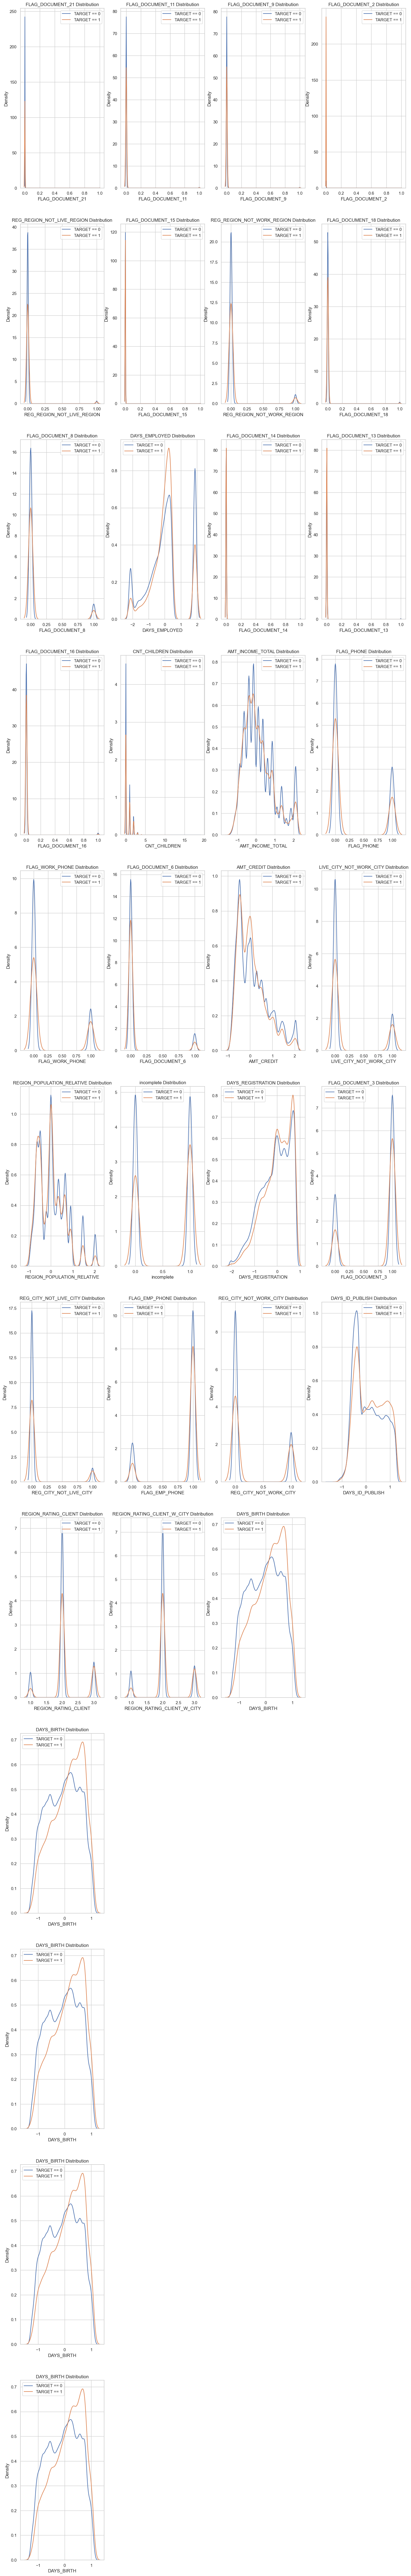

In [71]:
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")
gs = gridspec.GridSpec(12, 4)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(18,120))

columns = df_numerical.columns.values
c = 0
for i in range(12):
    for j in range (4):
        ax = plt.subplot(gs[i, j])
#         kde_target(columns[c], df_imputed_new)
        
        # Plot the distribution for target == 0 and target == 1
        sns.kdeplot(df_imputed_new.loc[(df_imputed_new['TARGET'] == 0)][columns[c]], label = 'TARGET == 0')
        sns.kdeplot(df_imputed_new.loc[(df_imputed_new['TARGET'] == 1)][columns[c]], label = 'TARGET == 1')

        # label the plot
        plt.xlabel(columns[c]); plt.ylabel('Density'); plt.title('%s Distribution' % columns[c])
        plt.legend();
        
        if c==len(columns)-1:
            break
        c+=1

# **Categorical variables**

### ***Chi-sqaure test for Categorical variables null hupothesis: p-value < .05***



In [72]:
import scipy

columns =df_categorical.columns.values

for col in columns:
    chi_square_args = pd.crosstab(df_categorical[col], df_train['TARGET']).values

    _, p_value, _, _ = scipy.stats.chi2_contingency(chi_square_args)
    print(f"The P-value for {col} = " ,p_value)

The P-value for NAME_CONTRACT_TYPE =  1.0235150721172847e-65
The P-value for CODE_GENDER =  1.1290217848908289e-200
The P-value for FLAG_OWN_CAR =  9.330994431109667e-34
The P-value for FLAG_OWN_REALTY =  0.0006681470317545887
The P-value for NAME_TYPE_SUITE =  1.1329313903575907e-05
The P-value for NAME_INCOME_TYPE =  1.9281456056861122e-266
The P-value for NAME_EDUCATION_TYPE =  2.4476812052198174e-219
The P-value for NAME_FAMILY_STATUS =  7.744841561414037e-107
The P-value for NAME_HOUSING_TYPE =  1.0990890032617707e-88
The P-value for OCCUPATION_TYPE =  3.7844998567642684e-288
The P-value for WEEKDAY_APPR_PROCESS_START =  0.01744736931389504
The P-value for ORGANIZATION_TYPE =  5.224541090300172e-299
The P-value for FONDKAPREMONT_MODE =  0.0007732982001133781
The P-value for HOUSETYPE_MODE =  9.992328040454538e-07
The P-value for WALLSMATERIAL_MODE =  1.4531802848120748e-27
The P-value for EMERGENCYSTATE_MODE =  1.1386802431747463e-06


# toutes les p-value sont inferieures à .05 

# get dummies

In [73]:

df_categorical_new = pd.get_dummies(df_categorical)

print('Features shape: ', df_categorical.shape)
print('new Features shape: ', df_categorical_new.shape)

Features shape:  (307511, 16)
new Features shape:  (307511, 140)


In [74]:
df_categorical_new

NAME_CONTRACT_TYPE_Cash loans  NAME_CONTRACT_TYPE_Revolving loans  \
0                                   1                                   0   
1                                   1                                   0   
2                                   0                                   1   
3                                   1                                   0   
4                                   1                                   0   
...                               ...                                 ...   
307506                              1                                   0   
307507                              1                                   0   
307508                              1                                   0   
307509                              1                                   0   
307510                              1                                   0   

        CODE_GENDER_F  CODE_GENDER_M  CODE_GENDER_XNA  FLAG_OWN_CAR_N  \
0                   0              1                0               1   
1                   1              0                0               1   
2                   0              1                0               0   
3                   1              0                0               1   
4                   0              1                0               1   
...               ...            ...              ...             ...   
307506              0              1                0               1   
307507              1              0                0               1   
307508              1              0                0               1   
307509              1              0                0               1   
307510              1              0                0               1   

        FLAG_OWN_CAR_Y  FLAG_OWN_REALTY_N  FLAG_OWN_REALTY_Y  \
0                    0                  0                  1   
1                    0                  1                  0   
2                    1                  0                  1   
3                    0                  0                  1   
4                    0                  0                  1   
...                ...                ...                ...   
307506               0                  1                  0   
307507               0                  0                  1   
307508               0                  0                  1   
307509               0                  0                  1   
307510               0                  1                  0   

        NAME_TYPE_SUITE_Children  ...  HOUSETYPE_MODE_terraced house  \
0                              0  ...                              0   
1                              0  ...                              0   
2                              0  ...                              0   
3                              0  ...                              0   
4                              0  ...                              0   
...                          ...  ...                            ...   
307506                         0  ...                              0   
307507                         0  ...                              0   
307508                         0  ...                              0   
307509                         0  ...                              0   
307510                         0  ...                              0   

        WALLSMATERIAL_MODE_Block  WALLSMATERIAL_MODE_Mixed  \
0                              0                         0   
1                              1                         0   
2                              0                         0   
3                              0                         0   
4                              0                         0   
...                          ...                       ...   
307506                         0                         0   
307507                         0                         0   
307508        

In [75]:
id = df_imputed_new["SK_ID_CURR"]
id

0        -1.001140
1        -1.001135
2        -1.001129
3        -1.001118
4        -1.001112
            ...   
307506    1.000292
307507    1.000298
307508    1.000303
307509    1.000309
307510    1.000315
Name: SK_ID_CURR, Length: 307511, dtype: float64

# à present df_train = concat get dummies et df_numerical

In [76]:
df_train = pd.concat([df_categorical_new,df_numerical],axis = 1)

In [77]:
df_train.shape

(307511, 171)

# Reading test data

In [78]:
#Read Test dataframe
df_test = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/application_test.csv')

In [79]:
df_test.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

In [80]:
# Testing data features
df_test.head()
print('Testing data shape: ', df_test.shape)


Testing data shape:  (48744, 121)


In [81]:
df_test_new = df_test.copy()
df_test_new = pd.get_dummies(df_test_new)
print('new Features shape before dropping : ', df_test_new.shape)
df_test_new = df_test_new.drop(columns = not_matched)
print('new Features shape: ', df_test_new.shape)

new Features shape before dropping :  (48744, 242)
new Features shape:  (48744, 223)


In [82]:
df_test_new

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0          100001             0          135000.0    568800.0      20560.5   
1          100005             0           99000.0    222768.0      17370.0   
2          100013             0          202500.0    663264.0      69777.0   
3          100028             2          315000.0   1575000.0      49018.5   
4          100038             1          180000.0    625500.0      32067.0   
...           ...           ...               ...         ...          ...   
48739      456221             0          121500.0    412560.0      17473.5   
48740      456222             2          157500.0    622413.0      31909.5   
48741      456223             1          202500.0    315000.0      33205.5   
48742      456224             0          225000.0    450000.0      25128.0   
48743      456250             0          135000.0    312768.0      24709.5   

       AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0             450000.0                    0.018850      -19241          -2329   
1             180000.0                    0.035792      -18064          -4469   
2             630000.0                    0.019101      -20038          -4458   
3            1575000.0                    0.026392      -13976          -1866   
4             625500.0                    0.010032      -13040          -2191   
...                ...                         ...         ...            ...   
48739         270000.0                    0.002042      -19970          -5169   
48740         495000.0                    0.035792      -11186          -1149   
48741         315000.0                    0.026392      -15922          -3037   
48742         450000.0                    0.018850      -13968          -2731   
48743         270000.0                    0.006629      -13962           -633   

       DAYS_REGISTRATION  ...  HOUSETYPE_MODE_terraced house  \
0                -5170.0  ...                              0   
1                -9118.0  ...                              0   
2                -2175.0  ...                              0   
3                -2000.0  ...                              0   
4                -4000.0  ...                              0   
...                  ...  ...                            ...   
48739            -9094.0  ...                              0   
48740            -3015.0  ...                              0   
48741            -2681.0  ...                              0   
48742            -1461.0  ...                              0   
48743            -1072.0  ...                              0   

       WALLSMATERIAL_MODE_Block  WALLSMATERIAL_MODE_Mixed  \
0                             0                         0   
1                             0                         0   
2                             0                         0   
3                             0                         0   
4                             0                         0   
...                         ...                       ...   
48739                         0                         0   
48740                         0                         0   
48741                         0                         0   
48742                         0                         0   
48743                         0                         0   

       WALLSMATERIAL_MODE_Monolithic  WALLSMATERIAL_MODE_Others  \
0                                  0                          0   
1                                  0                          0   
2                                  0                          0   
3                                  0                          0   
4                                  0                          0   
...                              ...                        ...   
48739                              0                          0   
48740                              0                       

In [83]:
x = [ i for i in df_train.columns.values if i not in df_test_new.columns.values]
x

['CODE_GENDER_XNA',
 'NAME_INCOME_TYPE_Maternity leave',
 'NAME_FAMILY_STATUS_Unknown',
 'incomplete']

In [84]:
x = [ i for i in  df_test_new.columns.values  if i not in df_train.columns.values]
x

['SK_ID_CURR',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_

In [85]:
train_labels = df_imputed_new['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
df_train, df_test_new = df_train.align(df_test_new, join = 'inner', axis = 1)

# Add the target back in

print('Training Features shape: ', df_train.shape)
print('Testing Features shape: ', df_test_new.shape)

Training Features shape:  (307511, 167)
Testing Features shape:  (48744, 167)


In [86]:
df_train

NAME_CONTRACT_TYPE_Cash loans  NAME_CONTRACT_TYPE_Revolving loans  \
0                                   1                                   0   
1                                   1                                   0   
2                                   0                                   1   
3                                   1                                   0   
4                                   1                                   0   
...                               ...                                 ...   
307506                              1                                   0   
307507                              1                                   0   
307508                              1                                   0   
307509                              1                                   0   
307510                              1                                   0   

        CODE_GENDER_F  CODE_GENDER_M  FLAG_OWN_CAR_N  FLAG_OWN_CAR_Y  \
0                   0              1               1               0   
1                   1              0               1               0   
2                   0              1               0               1   
3                   1              0               1               0   
4                   0              1               1               0   
...               ...            ...             ...             ...   
307506              0              1               1               0   
307507              1              0               1               0   
307508              1              0               1               0   
307509              1              0               1               0   
307510              1              0               1               0   

        FLAG_OWN_REALTY_N  FLAG_OWN_REALTY_Y  NAME_TYPE_SUITE_Children  \
0                       0                  1                         0   
1                       1                  0                         0   
2                       0                  1                         0   
3                       0                  1                         0   
4                       0                  1                         0   
...                   ...                ...                       ...   
307506                  1                  0                         0   
307507                  0                  1                         0   
307508                  0                  1                         0   
307509                  0                  1                         0   
307510                  1                  0                         0   

        NAME_TYPE_SUITE_Family  ...  REGION_POPULATION_RELATIVE  \
0                            0  ...                   -0.002626   
1                            1  ...                   -0.820550   
2                            0  ...                   -0.472638   
3                            0  ...                   -0.580533   
4                            0  ...                    0.525969   
...                        ...  ...                         ...   
307506                       0  ...                    0.734898   
307507                       0  ...                    0.338425   
307508                       0  ...                   -0.742242   
307509                       0  ...                   -0.725572   
307510                       0  ...                    1.467010   

        DAYS_REGISTRATION  FLAG_DOCUMENT_3  REG_CITY_NOT_LIVE_CITY  \
0                0.156504                1                       0   
1                0.606637                1                       0   
2                0.044611                0                       0   
3               -0.974312                1                       0   
4                0.035287                0                       0   
...                   ...              ...                     ...   
307506          -0.722552         

In [87]:
df_test_new

NAME_CONTRACT_TYPE_Cash loans  NAME_CONTRACT_TYPE_Revolving loans  \
0                                  1                                   0   
1                                  1                                   0   
2                                  1                                   0   
3                                  1                                   0   
4                                  1                                   0   
...                              ...                                 ...   
48739                              1                                   0   
48740                              1                                   0   
48741                              1                                   0   
48742                              1                                   0   
48743                              1                                   0   

       CODE_GENDER_F  CODE_GENDER_M  FLAG_OWN_CAR_N  FLAG_OWN_CAR_Y  \
0                  1              0               1               0   
1                  0              1               1               0   
2                  0              1               0               1   
3                  1              0               1               0   
4                  0              1               0               1   
...              ...            ...             ...             ...   
48739              1              0               1               0   
48740              1              0               1               0   
48741              1              0               0               1   
48742              0              1               1               0   
48743              1              0               0               1   

       FLAG_OWN_REALTY_N  FLAG_OWN_REALTY_Y  NAME_TYPE_SUITE_Children  \
0                      0                  1                         0   
1                      0                  1                         0   
2                      0                  1                         0   
3                      0                  1                         0   
4                      1                  0                         0   
...                  ...                ...                       ...   
48739                  0                  1                         0   
48740                  1                  0                         0   
48741                  0                  1                         0   
48742                  1                  0                         0   
48743                  1                  0                         0   

       NAME_TYPE_SUITE_Family  ...  REGION_POPULATION_RELATIVE  \
0                           0  ...                    0.018850   
1                           0  ...                    0.035792   
2                           0  ...                    0.019101   
3                           0  ...                    0.026392   
4                           0  ...                    0.010032   
...                       ...  ...                         ...   
48739                       0  ...                    0.002042   
48740                       0  ...                    0.035792   
48741                       0  ...                    0.026392   
48742                       1  ...                    0.018850   
48743                       0  ...                    0.006629   

       DAYS_REGISTRATION  FLAG_DOCUMENT_3  REG_CITY_NOT_LIVE_CITY  \
0                -5170.0                1                       0   
1                -9118.0                1                       0   
2                -2175.0                0                       0   
3                -2000.0                1                       0   
4                -4000.0                1                       0   
...                  ...              ...                     ...   
48739            -9094.0                0                       0   
48740            -3

In [88]:
train_labels

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64

# Reading other files

In [89]:
# run functions and pre_settings
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [90]:
def bureau_bb():
    bureau = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv')
    bb = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv')

    # Credit duration and credit/account end date difference
    bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
    bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    
    # Credit to debt ratio and difference
    bureau['DEBT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
    bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']
    bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']
    bureau['BUREAU_CREDIT_DEBT_RATIO'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM']

    # CREDIT_DAY_OVERDUE :
    bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
    bureau['BUREAU_IS_DPD_OVER120'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 120 else 0)
    
    nan_as_category = True

    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size', 'mean']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']

    #Status of Credit Bureau loan during the month
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean', 'min'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean', 'max', 'sum'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean', 'sum'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
        'SK_ID_BUREAU': ['count'],
        'DAYS_ENDDATE_FACT': ['min', 'max', 'mean'],
        'ENDDATE_DIF': ['min', 'max', 'mean'],
        'BUREAU_CREDIT_FACT_DIFF': ['min', 'max', 'mean'],
        'BUREAU_CREDIT_ENDDATE_DIFF': ['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_RATIO': ['min', 'max', 'mean'],
        'DEBT_CREDIT_DIFF': ['min', 'max', 'mean'],
        'BUREAU_IS_DPD': ['mean', 'sum'],
        'BUREAU_IS_DPD_OVER120': ['mean', 'sum']
        }

    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

    print('"Bureau/Bureau Balance" final shape:', bureau_agg.shape)
    return bureau_agg


## View new Features

In [91]:

New_df = bureau_bb()

"Bureau/Bureau Balance" final shape: (305811, 200)


In [92]:
New_df.head()

BURO_DAYS_CREDIT_MIN  BURO_DAYS_CREDIT_MAX  BURO_DAYS_CREDIT_MEAN  \
SK_ID_CURR                                                                      
100001                     -1572                   -49            -735.000000   
100002                     -1437                  -103            -874.000000   
100003                     -2586                  -606           -1400.750000   
100004                     -1326                  -408            -867.000000   
100005                      -373                   -62            -190.666667   

            BURO_DAYS_CREDIT_VAR  BURO_DAYS_CREDIT_ENDDATE_MIN  \
SK_ID_CURR                                                       
100001             240043.666667                       -1329.0   
100002             186150.000000                       -1072.0   
100003             827783.583333                       -2434.0   
100004             421362.000000                        -595.0   
100005              26340.333333                        -128.0   

            BURO_DAYS_CREDIT_ENDDATE_MAX  BURO_DAYS_CREDIT_ENDDATE_MEAN  \
SK_ID_CURR                                                                
100001                            1778.0                      82.428571   
100002                             780.0                    -349.000000   
100003                            1216.0                    -544.500000   
100004                            -382.0                    -488.500000   
100005                            1324.0                     439.333333   

            BURO_DAYS_CREDIT_UPDATE_MEAN  BURO_CREDIT_DAY_OVERDUE_MAX  \
SK_ID_CURR                                                              
100001                        -93.142857                            0   
100002                       -499.875000                            0   
100003                       -816.000000                            0   
100004                       -532.000000                            0   
100005                        -54.333333                            0   

            BURO_CREDIT_DAY_OVERDUE_MEAN  ...  \
SK_ID_CURR                                ...   
100001                               0.0  ...   
100002                               0.0  ...   
100003                               0.0  ...   
100004                               0.0  ...   
100005                               0.0  ...   

            CLOSED_BUREAU_CREDIT_DEBT_RATIO_MIN  \
SK_ID_CURR                                        
100001                                      0.0   
100002                                      0.0   
100003                                      0.0   
100004                                      0.0   
100005                                      0.0   

            CLOSED_BUREAU_CREDIT_DEBT_RATIO_MAX  \
SK_ID_CURR                                        
100001                                      0.0   
100002                                      0.0   
100003                                      0.0   
100004                                      0.0   
100005                                      0.0   

            CLOSED_BUREAU_CREDIT_DEBT_RATIO_MEAN  CLOSED_DEBT_CREDIT_DIFF_MIN  \
SK_ID_CURR                                                                      
100001                                       0.0                      85500.0   
100002                                       0.0                          0.0   
100003                                       0.0                      22248.0   
100004                                       0.0                      94500.0   
100005                                       0.0                      58500.0   

            CLOSED_DEBT_CREDIT_DIFF_MAX  CLOSED_DEBT_CREDIT_DIFF_MEAN  \
SK_ID_CURR                                                              
100001                         279720.0                      142335.0   
100002                         135000.0                       85245.0   
100003                 

## Analysis For The new Features and Wheather they are More Correlated to the Target Variable

In [93]:
df_trainx = pd.read_csv("Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv")

df_train_new = df_trainx[["SK_ID_CURR","TARGET"]].merge(bureau_bb(), how='left', on='SK_ID_CURR')


"Bureau/Bureau Balance" final shape: (305811, 200)


In [94]:
df_train_new.shape

(307511, 202)

### **Visualize The Correlation between the new Features and the target**

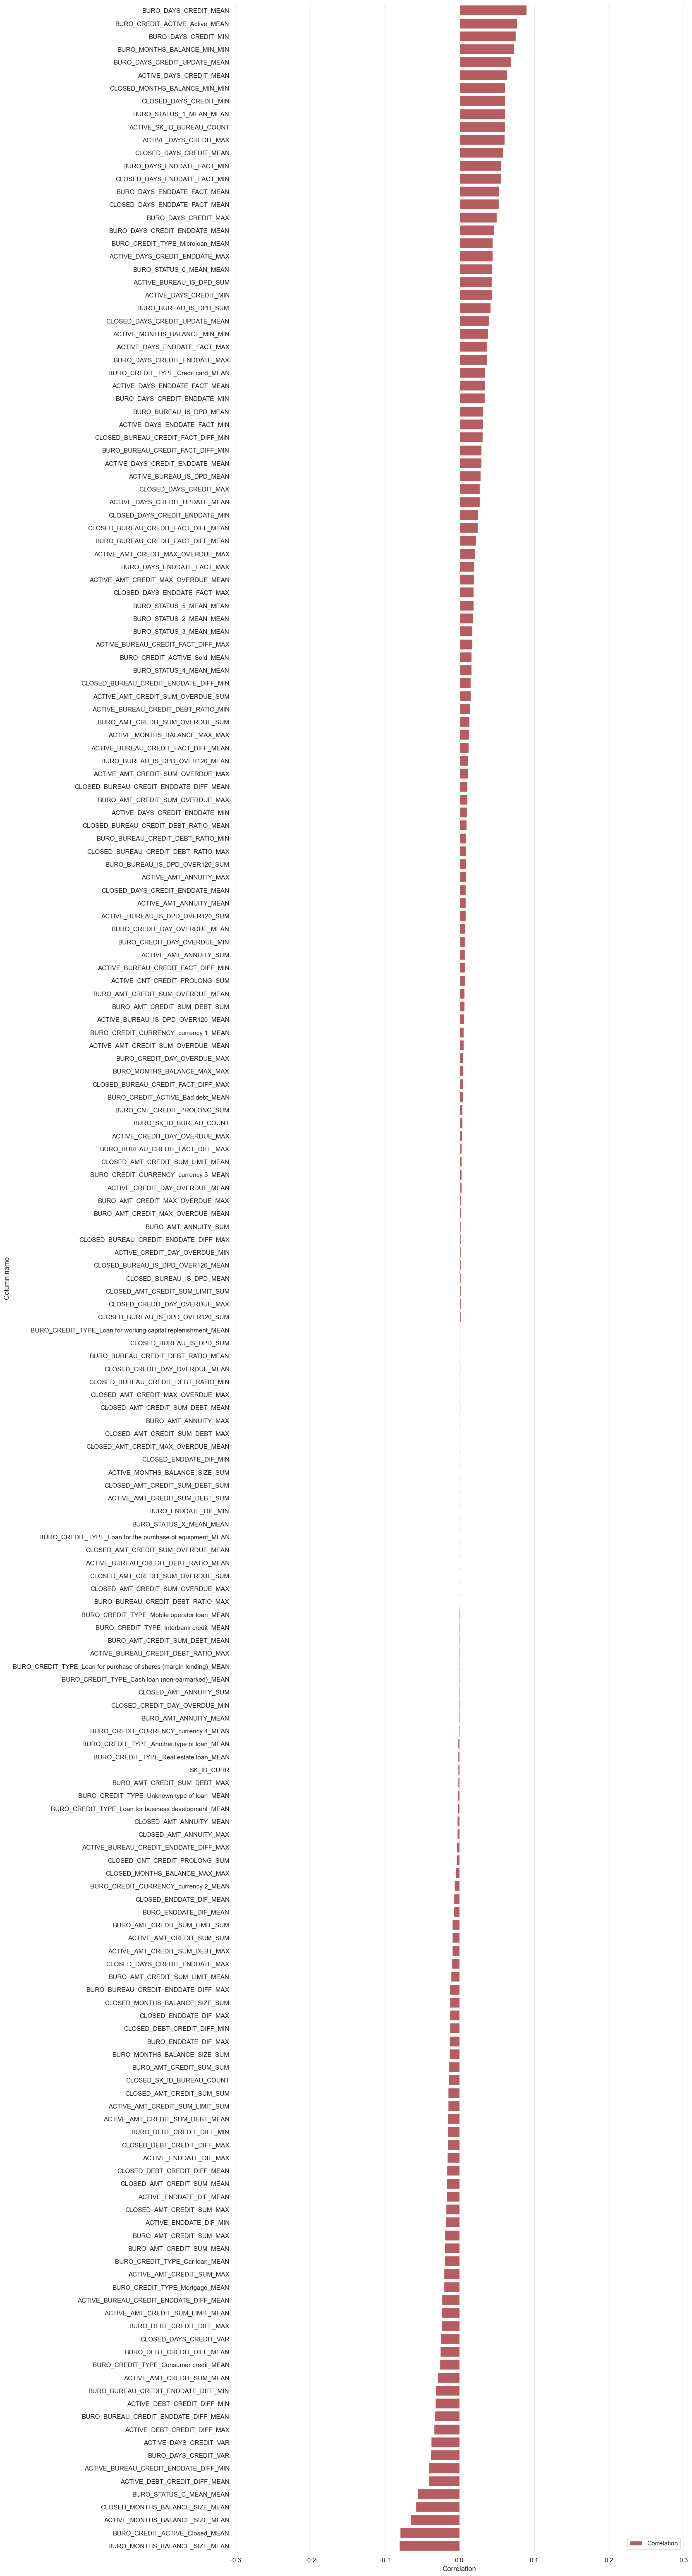

In [95]:
plt.figure(figsize=(14,80))
# sns.set_color_codes("dark")
y_corr = df_train_new.corr().loc["TARGET"].sort_values(ascending=False).drop("TARGET",axis = 0).dropna()

ax = sns.barplot(y=y_corr.index.values, x=y_corr.values,
            label="Correlation", color="r")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(-0.3, 0.3), ylabel="Column name",
       xlabel="Correlation")
sns.despine(left=True, bottom=True)

In [96]:
df_train_new

SK_ID_CURR  TARGET  BURO_DAYS_CREDIT_MIN  BURO_DAYS_CREDIT_MAX  \
0           100002       1               -1437.0                -103.0   
1           100003       0               -2586.0                -606.0   
2           100004       0               -1326.0                -408.0   
3           100006       0                   NaN                   NaN   
4           100007       0               -1149.0               -1149.0   
...            ...     ...                   ...                   ...   
307506      456251       0                   NaN                   NaN   
307507      456252       0                   NaN                   NaN   
307508      456253       0                -919.0                -713.0   
307509      456254       1               -1104.0               -1104.0   
307510      456255       0               -2337.0                -363.0   

        BURO_DAYS_CREDIT_MEAN  BURO_DAYS_CREDIT_VAR  \
0                 -874.000000         186150.000000   
1                -1400.750000         827783.583333   
2                 -867.000000         421362.000000   
3                         NaN                   NaN   
4                -1149.000000                   NaN   
...                       ...                   ...   
307506                    NaN                   NaN   
307507                    NaN                   NaN   
307508            -867.500000          10609.000000   
307509           -1104.000000                   NaN   
307510           -1089.454545         502786.672727   

        BURO_DAYS_CREDIT_ENDDATE_MIN  BURO_DAYS_CREDIT_ENDDATE_MAX  \
0                            -1072.0                         780.0   
1                            -2434.0                        1216.0   
2                             -595.0                        -382.0   
3                                NaN                           NaN   
4                             -783.0                        -783.0   
...                              ...                           ...   
307506                           NaN                           NaN   
307507                           NaN                           NaN   
307508                        -189.0                        1113.0   
307509                        -859.0                        -859.0   
307510                       -1243.0                       27320.0   

        BURO_DAYS_CREDIT_ENDDATE_MEAN  BURO_DAYS_CREDIT_UPDATE_MEAN  ...  \
0                         -349.000000                   -499.875000  ...   
1                         -544.500000                   -816.000000  ...   
2                         -488.500000                   -532.000000  ...   
3                                 NaN                           NaN  ...   
4                         -783.000000                   -783.000000  ...   
...                               ...                           ...  ...   
307506                            NaN                           NaN  ...   
307507                            NaN                           NaN  ...   
307508                     280.500000                   -253.250000  ...   
307509                    -859.000000                   -401.000000  ...   
307510                    3231.272727                   -531.090909  ...   

        CLOSED_BUREAU_CREDIT_DEBT_RATIO_MIN  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       NaN   
4                                       0.0   
...                                     ...   
307506                                  NaN   
307507                                  NaN   
307508                                  0.0   
307509                                  0.0   
307510                                  0.0   

        CLOSED_BUREAU_CREDIT_DEBT_RATIO_MAX  \
0                                       0.0   
1                                       0.0  

In [97]:
df_train_new.isnull().sum()

SK_ID_CURR                               0
TARGET                                   0
BURO_DAYS_CREDIT_MIN                 44020
BURO_DAYS_CREDIT_MAX                 44020
BURO_DAYS_CREDIT_MEAN                44020
                                     ...  
CLOSED_DEBT_CREDIT_DIFF_MEAN         89178
CLOSED_BUREAU_IS_DPD_MEAN            77346
CLOSED_BUREAU_IS_DPD_SUM             77346
CLOSED_BUREAU_IS_DPD_OVER120_MEAN    77346
CLOSED_BUREAU_IS_DPD_OVER120_SUM     77346
Length: 202, dtype: int64

In [98]:
df_train_new = df_train_new.fillna(df_train_new.median())

In [99]:
test_df2 = test(df_train_new)

In [100]:
test_df2

Column name  normality  homogeneity
0                           SK_ID_CURR          1            0
1                               TARGET          0            0
2                 BURO_DAYS_CREDIT_MIN          1            1
3                 BURO_DAYS_CREDIT_MAX          1            1
4                BURO_DAYS_CREDIT_MEAN          1            0
..                                 ...        ...          ...
197       CLOSED_DEBT_CREDIT_DIFF_MEAN          1            1
198          CLOSED_BUREAU_IS_DPD_MEAN          1            0
199           CLOSED_BUREAU_IS_DPD_SUM          1            0
200  CLOSED_BUREAU_IS_DPD_OVER120_MEAN          1            0
201   CLOSED_BUREAU_IS_DPD_OVER120_SUM          1            0

[202 rows x 3 columns]

In [101]:
test_df2.loc[(test_df2["normality"] == 1) &(test_df2["homogeneity"] == 1)]

Column name  normality  homogeneity
2                      BURO_DAYS_CREDIT_MIN          1            1
3                      BURO_DAYS_CREDIT_MAX          1            1
5                      BURO_DAYS_CREDIT_VAR          1            1
6              BURO_DAYS_CREDIT_ENDDATE_MIN          1            1
7              BURO_DAYS_CREDIT_ENDDATE_MAX          1            1
..                                      ...        ...          ...
190   CLOSED_BUREAU_CREDIT_ENDDATE_DIFF_MAX          1            1
191  CLOSED_BUREAU_CREDIT_ENDDATE_DIFF_MEAN          1            1
195             CLOSED_DEBT_CREDIT_DIFF_MIN          1            1
196             CLOSED_DEBT_CREDIT_DIFF_MAX          1            1
197            CLOSED_DEBT_CREDIT_DIFF_MEAN          1            1

[124 rows x 3 columns]

## Make t-test for the new Variables to see if they were independent from the TARGET

In [102]:
acc, rej  = t_test(df_train_new,test_df2)

In [103]:
rej

['BURO_DAYS_CREDIT_MIN',
 'BURO_DAYS_CREDIT_MAX',
 'BURO_DAYS_CREDIT_VAR',
 'BURO_DAYS_CREDIT_ENDDATE_MIN',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'BURO_DAYS_CREDIT_ENDDATE_MEAN',
 'BURO_DAYS_CREDIT_UPDATE_MEAN',
 'BURO_CREDIT_DAY_OVERDUE_MAX',
 'BURO_CREDIT_DAY_OVERDUE_MEAN',
 'BURO_CREDIT_DAY_OVERDUE_MIN',
 'BURO_AMT_CREDIT_SUM_MAX',
 'BURO_AMT_CREDIT_SUM_MEAN',
 'BURO_AMT_CREDIT_SUM_SUM',
 'BURO_AMT_CREDIT_SUM_DEBT_MAX',
 'BURO_AMT_CREDIT_SUM_OVERDUE_MEAN',
 'BURO_AMT_CREDIT_SUM_OVERDUE_MAX',
 'BURO_AMT_CREDIT_SUM_OVERDUE_SUM',
 'BURO_AMT_CREDIT_SUM_LIMIT_MEAN',
 'BURO_AMT_CREDIT_SUM_LIMIT_SUM',
 'BURO_MONTHS_BALANCE_MIN_MIN',
 'BURO_MONTHS_BALANCE_SIZE_SUM',
 'BURO_DAYS_ENDDATE_FACT_MIN',
 'BURO_DAYS_ENDDATE_FACT_MAX',
 'BURO_DAYS_ENDDATE_FACT_MEAN',
 'BURO_ENDDATE_DIF_MAX',
 'BURO_ENDDATE_DIF_MEAN',
 'BURO_BUREAU_CREDIT_FACT_DIFF_MIN',
 'BURO_BUREAU_CREDIT_FACT_DIFF_MAX',
 'BURO_BUREAU_CREDIT_FACT_DIFF_MEAN',
 'BURO_BUREAU_CREDIT_ENDDATE_DIFF_MIN',
 'BURO_BUREAU_CREDIT_ENDDATE_DIFF_MAX

## Merge The New Data and Features with the main Dataframes

In [104]:
df_test_new = pd.concat([df_test_new,df_test["SK_ID_CURR"]],axis = 1)
df_train_new = pd.concat([df_train,df_trainx["SK_ID_CURR"]],axis = 1)

df_train_2 = df_train_new.merge(bureau_bb(), how='left', on='SK_ID_CURR')
df_test_2 = df_test_new.merge(bureau_bb(), how='left', on='SK_ID_CURR')

print('--=> df after merge with bureau:', df_train.shape)
print('--=> df_train_2 after merge with bureau:', df_train_2.shape)

print('--=> df after merge with bureau:', df_test.shape)
print('--=> df_test_2 after merge with bureau:', df_test_2.shape)

"Bureau/Bureau Balance" final shape: (305811, 200)
"Bureau/Bureau Balance" final shape: (305811, 200)
--=> df after merge with bureau: (307511, 167)
--=> df_train_2 after merge with bureau: (307511, 368)
--=> df after merge with bureau: (48744, 121)
--=> df_test_2 after merge with bureau: (48744, 368)


In [105]:
df_train_2

NAME_CONTRACT_TYPE_Cash loans  NAME_CONTRACT_TYPE_Revolving loans  \
0                                   1                                   0   
1                                   1                                   0   
2                                   0                                   1   
3                                   1                                   0   
4                                   1                                   0   
...                               ...                                 ...   
307506                              1                                   0   
307507                              1                                   0   
307508                              1                                   0   
307509                              1                                   0   
307510                              1                                   0   

        CODE_GENDER_F  CODE_GENDER_M  FLAG_OWN_CAR_N  FLAG_OWN_CAR_Y  \
0                   0              1               1               0   
1                   1              0               1               0   
2                   0              1               0               1   
3                   1              0               1               0   
4                   0              1               1               0   
...               ...            ...             ...             ...   
307506              0              1               1               0   
307507              1              0               1               0   
307508              1              0               1               0   
307509              1              0               1               0   
307510              1              0               1               0   

        FLAG_OWN_REALTY_N  FLAG_OWN_REALTY_Y  NAME_TYPE_SUITE_Children  \
0                       0                  1                         0   
1                       1                  0                         0   
2                       0                  1                         0   
3                       0                  1                         0   
4                       0                  1                         0   
...                   ...                ...                       ...   
307506                  1                  0                         0   
307507                  0                  1                         0   
307508                  0                  1                         0   
307509                  0                  1                         0   
307510                  1                  0                         0   

        NAME_TYPE_SUITE_Family  ...  CLOSED_BUREAU_CREDIT_DEBT_RATIO_MIN  \
0                            0  ...                                  0.0   
1                            1  ...                                  0.0   
2                            0  ...                                  0.0   
3                            0  ...                                  NaN   
4                            0  ...                                  0.0   
...                        ...  ...                                  ...   
307506                       0  ...                                  NaN   
307507                       0  ...                                  NaN   
307508                       0  ...                                  0.0   
307509                       0  ...                                  0.0   
307510                       0  ...                                  0.0   

        CLOSED_BUREAU_CREDIT_DEBT_RATIO_MAX  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       NaN   
4                                       0.0   
...                                     ...   
307506                                  NaN   
307507                                  

In [106]:
df_train_2.dtypes.value_counts()

float64    207
uint8      137
int64       24
dtype: int64

In [107]:
df_train_3= df_train_2.astype(float)


In [108]:
df_train_3.replace([np.inf, -np.inf], 0, inplace=True)

df_train_3

NAME_CONTRACT_TYPE_Cash loans  NAME_CONTRACT_TYPE_Revolving loans  \
0                                 1.0                                 0.0   
1                                 1.0                                 0.0   
2                                 0.0                                 1.0   
3                                 1.0                                 0.0   
4                                 1.0                                 0.0   
...                               ...                                 ...   
307506                            1.0                                 0.0   
307507                            1.0                                 0.0   
307508                            1.0                                 0.0   
307509                            1.0                                 0.0   
307510                            1.0                                 0.0   

        CODE_GENDER_F  CODE_GENDER_M  FLAG_OWN_CAR_N  FLAG_OWN_CAR_Y  \
0                 0.0            1.0             1.0             0.0   
1                 1.0            0.0             1.0             0.0   
2                 0.0            1.0             0.0             1.0   
3                 1.0            0.0             1.0             0.0   
4                 0.0            1.0             1.0             0.0   
...               ...            ...             ...             ...   
307506            0.0            1.0             1.0             0.0   
307507            1.0            0.0             1.0             0.0   
307508            1.0            0.0             1.0             0.0   
307509            1.0            0.0             1.0             0.0   
307510            1.0            0.0             1.0             0.0   

        FLAG_OWN_REALTY_N  FLAG_OWN_REALTY_Y  NAME_TYPE_SUITE_Children  \
0                     0.0                1.0                       0.0   
1                     1.0                0.0                       0.0   
2                     0.0                1.0                       0.0   
3                     0.0                1.0                       0.0   
4                     0.0                1.0                       0.0   
...                   ...                ...                       ...   
307506                1.0                0.0                       0.0   
307507                0.0                1.0                       0.0   
307508                0.0                1.0                       0.0   
307509                0.0                1.0                       0.0   
307510                1.0                0.0                       0.0   

        NAME_TYPE_SUITE_Family  ...  CLOSED_BUREAU_CREDIT_DEBT_RATIO_MIN  \
0                          0.0  ...                                  0.0   
1                          1.0  ...                                  0.0   
2                          0.0  ...                                  0.0   
3                          0.0  ...                                  NaN   
4                          0.0  ...                                  0.0   
...                        ...  ...                                  ...   
307506                     0.0  ...                                  NaN   
307507                     0.0  ...                                  NaN   
307508                     0.0  ...                                  0.0   
307509                     0.0  ...                                  0.0   
307510                     0.0  ...                                  0.0   

        CLOSED_BUREAU_CREDIT_DEBT_RATIO_MAX  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       NaN   
4                                       0.0   
...                                     ...   
307506                                  NaN   
307507                                  

In [109]:
train_3 = SimpleImputer(strategy='median').fit_transform(df_train_3)

In [110]:
train_3

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.]])

In [111]:
df_train_3=pd.DataFrame(train_3)
df_train_3.columns=df_train_2.columns
df_train_3

NAME_CONTRACT_TYPE_Cash loans  NAME_CONTRACT_TYPE_Revolving loans  \
0                                 1.0                                 0.0   
1                                 1.0                                 0.0   
2                                 0.0                                 1.0   
3                                 1.0                                 0.0   
4                                 1.0                                 0.0   
...                               ...                                 ...   
307506                            1.0                                 0.0   
307507                            1.0                                 0.0   
307508                            1.0                                 0.0   
307509                            1.0                                 0.0   
307510                            1.0                                 0.0   

        CODE_GENDER_F  CODE_GENDER_M  FLAG_OWN_CAR_N  FLAG_OWN_CAR_Y  \
0                 0.0            1.0             1.0             0.0   
1                 1.0            0.0             1.0             0.0   
2                 0.0            1.0             0.0             1.0   
3                 1.0            0.0             1.0             0.0   
4                 0.0            1.0             1.0             0.0   
...               ...            ...             ...             ...   
307506            0.0            1.0             1.0             0.0   
307507            1.0            0.0             1.0             0.0   
307508            1.0            0.0             1.0             0.0   
307509            1.0            0.0             1.0             0.0   
307510            1.0            0.0             1.0             0.0   

        FLAG_OWN_REALTY_N  FLAG_OWN_REALTY_Y  NAME_TYPE_SUITE_Children  \
0                     0.0                1.0                       0.0   
1                     1.0                0.0                       0.0   
2                     0.0                1.0                       0.0   
3                     0.0                1.0                       0.0   
4                     0.0                1.0                       0.0   
...                   ...                ...                       ...   
307506                1.0                0.0                       0.0   
307507                0.0                1.0                       0.0   
307508                0.0                1.0                       0.0   
307509                0.0                1.0                       0.0   
307510                1.0                0.0                       0.0   

        NAME_TYPE_SUITE_Family  ...  CLOSED_BUREAU_CREDIT_DEBT_RATIO_MIN  \
0                          0.0  ...                                  0.0   
1                          1.0  ...                                  0.0   
2                          0.0  ...                                  0.0   
3                          0.0  ...                                  0.0   
4                          0.0  ...                                  0.0   
...                        ...  ...                                  ...   
307506                     0.0  ...                                  0.0   
307507                     0.0  ...                                  0.0   
307508                     0.0  ...                                  0.0   
307509                     0.0  ...                                  0.0   
307510                     0.0  ...                                  0.0   

        CLOSED_BUREAU_CREDIT_DEBT_RATIO_MAX  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   
...                                     ...   
307506                                  0.0   
307507                                  

In [112]:
df_test_2

NAME_CONTRACT_TYPE_Cash loans  NAME_CONTRACT_TYPE_Revolving loans  \
0                                  1                                   0   
1                                  1                                   0   
2                                  1                                   0   
3                                  1                                   0   
4                                  1                                   0   
...                              ...                                 ...   
48739                              1                                   0   
48740                              1                                   0   
48741                              1                                   0   
48742                              1                                   0   
48743                              1                                   0   

       CODE_GENDER_F  CODE_GENDER_M  FLAG_OWN_CAR_N  FLAG_OWN_CAR_Y  \
0                  1              0               1               0   
1                  0              1               1               0   
2                  0              1               0               1   
3                  1              0               1               0   
4                  0              1               0               1   
...              ...            ...             ...             ...   
48739              1              0               1               0   
48740              1              0               1               0   
48741              1              0               0               1   
48742              0              1               1               0   
48743              1              0               0               1   

       FLAG_OWN_REALTY_N  FLAG_OWN_REALTY_Y  NAME_TYPE_SUITE_Children  \
0                      0                  1                         0   
1                      0                  1                         0   
2                      0                  1                         0   
3                      0                  1                         0   
4                      1                  0                         0   
...                  ...                ...                       ...   
48739                  0                  1                         0   
48740                  1                  0                         0   
48741                  0                  1                         0   
48742                  1                  0                         0   
48743                  1                  0                         0   

       NAME_TYPE_SUITE_Family  ...  CLOSED_BUREAU_CREDIT_DEBT_RATIO_MIN  \
0                           0  ...                                  0.0   
1                           0  ...                                  0.0   
2                           0  ...                                  0.0   
3                           0  ...                                  0.0   
4                           0  ...                                  NaN   
...                       ...  ...                                  ...   
48739                       0  ...                                  0.0   
48740                       0  ...                                  NaN   
48741                       0  ...                                  0.0   
48742                       1  ...                                  0.0   
48743                       0  ...                                  0.0   

       CLOSED_BUREAU_CREDIT_DEBT_RATIO_MAX  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      NaN   
...                                    ...   
48739                                  0.0   
48740                                  NaN   
48741                                  0.0   
487

### light GBM

In [113]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [114]:
#mlflow.lightgbm.autolog()  # Enable auto logging.


In [115]:
import re
df_train = df_train_3.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

df_test = df_test_2.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

folds = KFold(n_splits=5, shuffle=True, random_state=2020)

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train, train_labels)):
        train_x, train_y = df_train.iloc[train_idx], train_labels.iloc[train_idx]
        valid_x, valid_y = df_train.iloc[valid_idx], train_labels.iloc[valid_idx]
        
        clf = LGBMClassifier(nthread=-1,
                            n_estimators=5000,
                            learning_rate=0.01,
                            max_depth=11,
                            num_leaves=58,
                            colsample_bytree=0.613,
                            subsample=0.708,
                            max_bin=407,
                            reg_alpha=3.564,
                            reg_lambda=4.930,
                            min_child_weight=6,
                            min_child_samples=165,
                            silent=-1,
                            verbose=-1,)

        with mlflow.start_run():
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric='auc', verbose=500, early_stopping_rounds=500)
        
        # Create arrays and dataframes to store results
        train_preds = np.zeros(df_train.shape[0])
        test_preds = np.zeros(df_test.shape[0])
        
        train_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        test_preds += clf.predict_proba(df_test, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, train_preds[valid_idx])))


print('Full AUC score %.6f' % roc_auc_score(df_imputed_new['TARGET'], train_preds))


df_test['TARGET'] = test_preds


[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 500 rounds
[500]	training's auc: 0.770773	training's binary_logloss: 0.245542	valid_1's auc: 0.725025	valid_1's binary_logloss: 0.25235
[1000]	training's auc: 0.802868	training's binary_logloss: 0.235303	valid_1's auc: 0.730463	valid_1's binary_logloss: 0.250574
[1500]	training's auc: 0.828572	training's binary_logloss: 0.227243	valid_1's auc: 0.731337	valid_1's binary_logloss: 0.250222
[2000]	training's auc: 0.849341	training's binary_logloss: 0.220349	valid_1's auc: 0.731311	valid_1's binary_logloss: 0.250178
Early stopping, best iteration is:
[1698]	training's auc: 0.837148	training's binary_logloss: 0.224415	valid_1's auc: 0.731481	valid_1's binary_logloss: 0.250172
Fold  1 AUC : 0.731481
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
Trainin

In [116]:
train_preds

array([0.        , 0.02151022, 0.        , ..., 0.        , 0.        ,
       0.        ])

In [117]:
df_test = pd.read_csv("Projet+Mise+en+prod+-+home-credit-default-risk/application_test.csv")

In [118]:
df_test['TARGET'] = test_preds
df_test[['SK_ID_CURR', 'TARGET']].to_csv('submission.csv', index=False)
df_test

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0          100001         Cash loans           F            N               Y   
1          100005         Cash loans           M            N               Y   
2          100013         Cash loans           M            Y               Y   
3          100028         Cash loans           F            N               Y   
4          100038         Cash loans           M            Y               N   
...           ...                ...         ...          ...             ...   
48739      456221         Cash loans           F            N               Y   
48740      456222         Cash loans           F            N               N   
48741      456223         Cash loans           F            Y               Y   
48742      456224         Cash loans           M            N               N   
48743      456250         Cash loans           F            Y               N   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                 0          135000.0    568800.0      20560.5   
1                 0           99000.0    222768.0      17370.0   
2                 0          202500.0    663264.0      69777.0   
3                 2          315000.0   1575000.0      49018.5   
4                 1          180000.0    625500.0      32067.0   
...             ...               ...         ...          ...   
48739             0          121500.0    412560.0      17473.5   
48740             2          157500.0    622413.0      31909.5   
48741             1          202500.0    315000.0      33205.5   
48742             0          225000.0    450000.0      25128.0   
48743             0          135000.0    312768.0      24709.5   

       AMT_GOODS_PRICE  ... FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
0             450000.0  ...                0                0   
1             180000.0  ...                0                0   
2             630000.0  ...                0                0   
3            1575000.0  ...                0                0   
4             625500.0  ...                0                0   
...                ...  ...              ...              ...   
48739         270000.0  ...                0                0   
48740         495000.0  ...                0                0   
48741         315000.0  ...                0                0   
48742         450000.0  ...                0                0   
48743         270000.0  ...                0                0   

      FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                    0                        0.0                       0.0   
1                    0                        0.0                       0.0   
2                    0                        0.0                       0.0   
3                    0                        0.0                       0.0   
4                    0                        NaN                       NaN   
...                ...                        ...                       ...   
48739                0                        0.0                       0.0   
48740                0                        NaN                       NaN   
48741                0                        0.0                       0.0   
48742                0                        0.0                       0.0   
48743                0                        0.0                       0.0   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                             0.0                        0.0   
1                             0.0                        0.0   
2                             0.0                        0.0   
3                             0.0                        0.0   
4                             NaN                        NaN   
...                           ...                        ...   
48739                         0.0                        0.0   

In [119]:
df_train

NAME_CONTRACT_TYPE_Cashloans  NAME_CONTRACT_TYPE_Revolvingloans  \
0                                1.0                                0.0   
1                                1.0                                0.0   
2                                0.0                                1.0   
3                                1.0                                0.0   
4                                1.0                                0.0   
...                              ...                                ...   
307506                           1.0                                0.0   
307507                           1.0                                0.0   
307508                           1.0                                0.0   
307509                           1.0                                0.0   
307510                           1.0                                0.0   

        CODE_GENDER_F  CODE_GENDER_M  FLAG_OWN_CAR_N  FLAG_OWN_CAR_Y  \
0                 0.0            1.0             1.0             0.0   
1                 1.0            0.0             1.0             0.0   
2                 0.0            1.0             0.0             1.0   
3                 1.0            0.0             1.0             0.0   
4                 0.0            1.0             1.0             0.0   
...               ...            ...             ...             ...   
307506            0.0            1.0             1.0             0.0   
307507            1.0            0.0             1.0             0.0   
307508            1.0            0.0             1.0             0.0   
307509            1.0            0.0             1.0             0.0   
307510            1.0            0.0             1.0             0.0   

        FLAG_OWN_REALTY_N  FLAG_OWN_REALTY_Y  NAME_TYPE_SUITE_Children  \
0                     0.0                1.0                       0.0   
1                     1.0                0.0                       0.0   
2                     0.0                1.0                       0.0   
3                     0.0                1.0                       0.0   
4                     0.0                1.0                       0.0   
...                   ...                ...                       ...   
307506                1.0                0.0                       0.0   
307507                0.0                1.0                       0.0   
307508                0.0                1.0                       0.0   
307509                0.0                1.0                       0.0   
307510                1.0                0.0                       0.0   

        NAME_TYPE_SUITE_Family  ...  CLOSED_BUREAU_CREDIT_DEBT_RATIO_MIN  \
0                          0.0  ...                                  0.0   
1                          1.0  ...                                  0.0   
2                          0.0  ...                                  0.0   
3                          0.0  ...                                  0.0   
4                          0.0  ...                                  0.0   
...                        ...  ...                                  ...   
307506                     0.0  ...                                  0.0   
307507                     0.0  ...                                  0.0   
307508                     0.0  ...                                  0.0   
307509                     0.0  ...                                  0.0   
307510                     0.0  ...                                  0.0   

        CLOSED_BUREAU_CREDIT_DEBT_RATIO_MAX  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   
...                                     ...   
307506                                  0.0   
307507                                  0.0   
307508           

In [120]:
mlflow.end_run()

In [121]:
train_x, train_y = df_train_3.iloc[train_idx], train_labels.iloc[train_idx]
valid_x, valid_y = df_train_3.iloc[valid_idx], train_labels.iloc[valid_idx]

In [122]:
train_x

NAME_CONTRACT_TYPE_Cash loans  NAME_CONTRACT_TYPE_Revolving loans  \
0                                 1.0                                 0.0   
2                                 0.0                                 1.0   
3                                 1.0                                 0.0   
4                                 1.0                                 0.0   
5                                 1.0                                 0.0   
...                               ...                                 ...   
307506                            1.0                                 0.0   
307507                            1.0                                 0.0   
307508                            1.0                                 0.0   
307509                            1.0                                 0.0   
307510                            1.0                                 0.0   

        CODE_GENDER_F  CODE_GENDER_M  FLAG_OWN_CAR_N  FLAG_OWN_CAR_Y  \
0                 0.0            1.0             1.0             0.0   
2                 0.0            1.0             0.0             1.0   
3                 1.0            0.0             1.0             0.0   
4                 0.0            1.0             1.0             0.0   
5                 0.0            1.0             1.0             0.0   
...               ...            ...             ...             ...   
307506            0.0            1.0             1.0             0.0   
307507            1.0            0.0             1.0             0.0   
307508            1.0            0.0             1.0             0.0   
307509            1.0            0.0             1.0             0.0   
307510            1.0            0.0             1.0             0.0   

        FLAG_OWN_REALTY_N  FLAG_OWN_REALTY_Y  NAME_TYPE_SUITE_Children  \
0                     0.0                1.0                       0.0   
2                     0.0                1.0                       0.0   
3                     0.0                1.0                       0.0   
4                     0.0                1.0                       0.0   
5                     0.0                1.0                       0.0   
...                   ...                ...                       ...   
307506                1.0                0.0                       0.0   
307507                0.0                1.0                       0.0   
307508                0.0                1.0                       0.0   
307509                0.0                1.0                       0.0   
307510                1.0                0.0                       0.0   

        NAME_TYPE_SUITE_Family  ...  CLOSED_BUREAU_CREDIT_DEBT_RATIO_MIN  \
0                          0.0  ...                                  0.0   
2                          0.0  ...                                  0.0   
3                          0.0  ...                                  0.0   
4                          0.0  ...                                  0.0   
5                          0.0  ...                                  0.0   
...                        ...  ...                                  ...   
307506                     0.0  ...                                  0.0   
307507                     0.0  ...                                  0.0   
307508                     0.0  ...                                  0.0   
307509                     0.0  ...                                  0.0   
307510                     0.0  ...                                  0.0   

        CLOSED_BUREAU_CREDIT_DEBT_RATIO_MAX  \
0                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   
5                                       0.0   
...                                     ...   
307506                                  0.0   
307507                                  

In [123]:
train_labels

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64

In [124]:
train_preds_2=np.rint (train_preds)
train_preds_2

array([0., 0., 0., ..., 0., 0., 0.])

In [125]:
for x in range(len(train_preds_2)):
    if(train_preds_2[x]==1):
        train_preds_2[x] = 0
    else:
        train_preds_2[x] = 1
  

In [126]:
f1_score(train_preds_2, train_labels)


0.149123995100031

#  Oversampling


In [127]:
sm=SMOTE(random_state=42)
X_resampled, y_resampled=sm.fit_resample(train_x, train_y)

In [128]:
X_resampled

NAME_CONTRACT_TYPE_Cash loans  NAME_CONTRACT_TYPE_Revolving loans  \
0                             1.00000                             0.00000   
1                             0.00000                             1.00000   
2                             1.00000                             0.00000   
3                             1.00000                             0.00000   
4                             1.00000                             0.00000   
...                               ...                                 ...   
452447                        1.00000                             0.00000   
452448                        1.00000                             0.00000   
452449                        1.00000                             0.00000   
452450                        0.66469                             0.33531   
452451                        1.00000                             0.00000   

        CODE_GENDER_F  CODE_GENDER_M  FLAG_OWN_CAR_N  FLAG_OWN_CAR_Y  \
0            0.000000       1.000000        1.000000        0.000000   
1            0.000000       1.000000        0.000000        1.000000   
2            1.000000       0.000000        1.000000        0.000000   
3            0.000000       1.000000        1.000000        0.000000   
4            0.000000       1.000000        1.000000        0.000000   
...               ...            ...             ...             ...   
452447       1.000000       0.000000        1.000000        0.000000   
452448       0.387846       0.612154        1.000000        0.000000   
452449       1.000000       0.000000        1.000000        0.000000   
452450       0.664690       0.335310        1.000000        0.000000   
452451       0.000000       1.000000        0.973089        0.026911   

        FLAG_OWN_REALTY_N  FLAG_OWN_REALTY_Y  NAME_TYPE_SUITE_Children  \
0                0.000000           1.000000                       0.0   
1                0.000000           1.000000                       0.0   
2                0.000000           1.000000                       0.0   
3                0.000000           1.000000                       0.0   
4                0.000000           1.000000                       0.0   
...                   ...                ...                       ...   
452447           0.000000           1.000000                       0.0   
452448           0.387846           0.612154                       0.0   
452449           0.000000           1.000000                       0.0   
452450           0.335310           0.664690                       0.0   
452451           0.973089           0.026911                       0.0   

        NAME_TYPE_SUITE_Family  ...  CLOSED_BUREAU_CREDIT_DEBT_RATIO_MIN  \
0                     0.000000  ...                                  0.0   
1                     0.000000  ...                                  0.0   
2                     0.000000  ...                                  0.0   
3                     0.000000  ...                                  0.0   
4                     0.000000  ...                                  0.0   
...                        ...  ...                                  ...   
452447                0.184507  ...                                  0.0   
452448                0.000000  ...                                  0.0   
452449                0.000000  ...                                  0.0   
452450                0.000000  ...                                  0.0   
452451                0.000000  ...                                  0.0   

        CLOSED_BUREAU_CREDIT_DEBT_RATIO_MAX  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   
...                                     ...   
452447                                  0.0   
452448                                  

In [129]:
y_resampled

0         1
1         0
2         0
3         0
4         0
         ..
452447    1
452448    1
452449    1
452450    1
452451    1
Name: TARGET, Length: 452452, dtype: int64

In [130]:
df_train = X_resampled.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

df_test = df_test_2.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

folds = KFold(n_splits=5, shuffle=True, random_state=2020)

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train, y_resampled)):
        train_x, train_y = df_train.iloc[train_idx], y_resampled.iloc[train_idx]
        valid_x, valid_y = df_train.iloc[valid_idx], y_resampled.iloc[valid_idx]
        
        clf = LGBMClassifier(nthread=-1,
                            n_estimators=5000,
                            learning_rate=0.01,
                            max_depth=11,
                            num_leaves=58,
                            colsample_bytree=0.613,
                            subsample=0.708,
                            max_bin=407,
                            reg_alpha=3.564,
                            reg_lambda=4.930,
                            min_child_weight=6,
                            min_child_samples=165,
                            silent=-1,
                            verbose=-1,)

        with mlflow.start_run():
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric='auc', verbose=500, early_stopping_rounds=500)
        
        # Create arrays and dataframes to store results
        train_preds = np.zeros(df_train.shape[0])
        test_preds = np.zeros(df_test.shape[0])
        
        train_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        test_preds += clf.predict_proba(df_test, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, train_preds[valid_idx])))


print('Full AUC score %.6f' % roc_auc_score(y_resampled, train_preds))


df_test['TARGET'] = test_preds


[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 500 rounds
[500]	training's auc: 0.977738	training's binary_logloss: 0.146118	valid_1's auc: 0.975842	valid_1's binary_logloss: 0.14747
[1000]	training's auc: 0.98147	training's binary_logloss: 0.132052	valid_1's auc: 0.976882	valid_1's binary_logloss: 0.138237
[1500]	training's auc: 0.984318	training's binary_logloss: 0.125603	valid_1's auc: 0.977142	valid_1's binary_logloss: 0.136706
[2000]	training's auc: 0.986583	training's binary_logloss: 0.120627	valid_1's auc: 0.977188	valid_1's binary_logloss: 0.136269
[2500]	training's auc: 0.988466	training's binary_logloss: 0.116238	valid_1's auc: 0.977229	valid_1's binary_logloss: 0.136014
[3000]	training's auc: 0.990062	training's binary_logloss: 0.112243	valid_1's auc: 0.977238	valid_1's binary_logloss: 0.135893
Early stopping, best iteration is:
[2663]	training's auc: 0

In [131]:
valid_x

NAME_CONTRACT_TYPE_Cashloans  NAME_CONTRACT_TYPE_Revolvingloans  \
6                                1.0                                0.0   
20                               1.0                                0.0   
25                               1.0                                0.0   
31                               0.0                                1.0   
34                               1.0                                0.0   
...                              ...                                ...   
452425                           1.0                                0.0   
452426                           1.0                                0.0   
452432                           1.0                                0.0   
452433                           1.0                                0.0   
452437                           1.0                                0.0   

        CODE_GENDER_F  CODE_GENDER_M  FLAG_OWN_CAR_N  FLAG_OWN_CAR_Y  \
6            1.000000       0.000000        1.000000        0.000000   
20           1.000000       0.000000        1.000000        0.000000   
25           1.000000       0.000000        1.000000        0.000000   
31           0.000000       1.000000        0.000000        1.000000   
34           1.000000       0.000000        1.000000        0.000000   
...               ...            ...             ...             ...   
452425       0.813259       0.186741        1.000000        0.000000   
452426       0.810950       0.189050        0.810950        0.189050   
452432       0.911180       0.088820        0.000000        1.000000   
452433       1.000000       0.000000        0.954937        0.045063   
452437       0.064897       0.935103        0.935103        0.064897   

        FLAG_OWN_REALTY_N  FLAG_OWN_REALTY_Y  NAME_TYPE_SUITE_Children  \
6                0.000000           1.000000                       1.0   
20               0.000000           1.000000                       0.0   
25               1.000000           0.000000                       0.0   
31               0.000000           1.000000                       0.0   
34               1.000000           0.000000                       0.0   
...                   ...                ...                       ...   
452425           0.186741           0.813259                       0.0   
452426           0.000000           1.000000                       0.0   
452432           0.000000           1.000000                       0.0   
452433           0.000000           1.000000                       0.0   
452437           0.000000           1.000000                       0.0   

        NAME_TYPE_SUITE_Family  ...  CLOSED_BUREAU_CREDIT_DEBT_RATIO_MIN  \
6                      0.00000  ...                                  0.0   
20                     0.00000  ...                                  0.0   
25                     0.00000  ...                                  0.0   
31                     0.00000  ...                                  0.0   
34                     0.00000  ...                                  0.0   
...                        ...  ...                                  ...   
452425                 0.00000  ...                                  0.0   
452426                 0.18905  ...                                  0.0   
452432                 0.00000  ...                                  0.0   
452433                 0.00000  ...                                  0.0   
452437                 0.00000  ...                                  0.0   

        CLOSED_BUREAU_CREDIT_DEBT_RATIO_MAX  \
6                                       0.0   
20                                      1.0   
25                                      0.0   
31                                      0.0   
34                                      0.0   
...                                     ...   
452425                                  0.0   
452426                                  0.0   
452432           

In [179]:
train_x

NAME_CONTRACT_TYPE_Cashloans  NAME_CONTRACT_TYPE_Revolvingloans  \
0                            1.00000                            0.00000   
1                            0.00000                            1.00000   
2                            1.00000                            0.00000   
3                            1.00000                            0.00000   
4                            1.00000                            0.00000   
...                              ...                                ...   
452447                       1.00000                            0.00000   
452448                       1.00000                            0.00000   
452449                       1.00000                            0.00000   
452450                       0.66469                            0.33531   
452451                       1.00000                            0.00000   

        CODE_GENDER_F  CODE_GENDER_M  FLAG_OWN_CAR_N  FLAG_OWN_CAR_Y  \
0            0.000000       1.000000        1.000000        0.000000   
1            0.000000       1.000000        0.000000        1.000000   
2            1.000000       0.000000        1.000000        0.000000   
3            0.000000       1.000000        1.000000        0.000000   
4            0.000000       1.000000        1.000000        0.000000   
...               ...            ...             ...             ...   
452447       1.000000       0.000000        1.000000        0.000000   
452448       0.387846       0.612154        1.000000        0.000000   
452449       1.000000       0.000000        1.000000        0.000000   
452450       0.664690       0.335310        1.000000        0.000000   
452451       0.000000       1.000000        0.973089        0.026911   

        FLAG_OWN_REALTY_N  FLAG_OWN_REALTY_Y  NAME_TYPE_SUITE_Children  \
0                0.000000           1.000000                       0.0   
1                0.000000           1.000000                       0.0   
2                0.000000           1.000000                       0.0   
3                0.000000           1.000000                       0.0   
4                0.000000           1.000000                       0.0   
...                   ...                ...                       ...   
452447           0.000000           1.000000                       0.0   
452448           0.387846           0.612154                       0.0   
452449           0.000000           1.000000                       0.0   
452450           0.335310           0.664690                       0.0   
452451           0.973089           0.026911                       0.0   

        NAME_TYPE_SUITE_Family  ...  CLOSED_BUREAU_CREDIT_DEBT_RATIO_MIN  \
0                     0.000000  ...                                  0.0   
1                     0.000000  ...                                  0.0   
2                     0.000000  ...                                  0.0   
3                     0.000000  ...                                  0.0   
4                     0.000000  ...                                  0.0   
...                        ...  ...                                  ...   
452447                0.184507  ...                                  0.0   
452448                0.000000  ...                                  0.0   
452449                0.000000  ...                                  0.0   
452450                0.000000  ...                                  0.0   
452451                0.000000  ...                                  0.0   

        CLOSED_BUREAU_CREDIT_DEBT_RATIO_MAX  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   
...                                     ...   
452447                                  0.0   
452448                                  0.0   
452449           

In [168]:
explainer=shap.TreeExplainer(clf, train_x, feature_names=train_x.columns.tolist())

In [132]:
shap_values = explainer.shap_values(valid_x)

In [175]:
shap_values

[array([[ 0.00448806,  0.01793399,  0.05045401, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00338702,  0.0171218 ,  0.02912515, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00433013,  0.01877957,  0.02341771, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.00366948,  0.01361551, -0.97867857, ...,  0.        ,
          0.        ,  0.        ],
        [-0.00232866,  0.00971541,  0.0451455 , ...,  0.        ,
          0.        ,  0.        ],
        [-0.01126722,  0.0055619 , -0.74212989, ...,  0.        ,
          0.        ,  0.        ]]),
 array([[-0.00448806, -0.01793399, -0.05045401, ...,  0.        ,
          0.        ,  0.        ],
        [-0.00338702, -0.0171218 , -0.02912515, ...,  0.        ,
          0.        ,  0.        ],
        [-0.00433013, -0.01877957, -0.02341771, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.00366948, -0.01361551,  0.97867857, ...,  

In [178]:
shap_values[0].shape

(90490, 368)

In [188]:
len(shap_values[0].tolist())

90490

In [180]:
shap_values[0]

array([[ 0.00448806,  0.01793399,  0.05045401, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00338702,  0.0171218 ,  0.02912515, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00433013,  0.01877957,  0.02341771, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.00366948,  0.01361551, -0.97867857, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00232866,  0.00971541,  0.0451455 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.01126722,  0.0055619 , -0.74212989, ...,  0.        ,
         0.        ,  0.        ]])

In [193]:
np.save('shap-values', shap_values[0])

In [194]:
arr77=np.load('shap-values.npy')
arr77

array([[ 0.00448806,  0.01793399,  0.05045401, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00338702,  0.0171218 ,  0.02912515, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00433013,  0.01877957,  0.02341771, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.00366948,  0.01361551, -0.97867857, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00232866,  0.00971541,  0.0451455 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.01126722,  0.0055619 , -0.74212989, ...,  0.        ,
         0.        ,  0.        ]])

In [183]:
type(shap_values[0])

numpy.ndarray

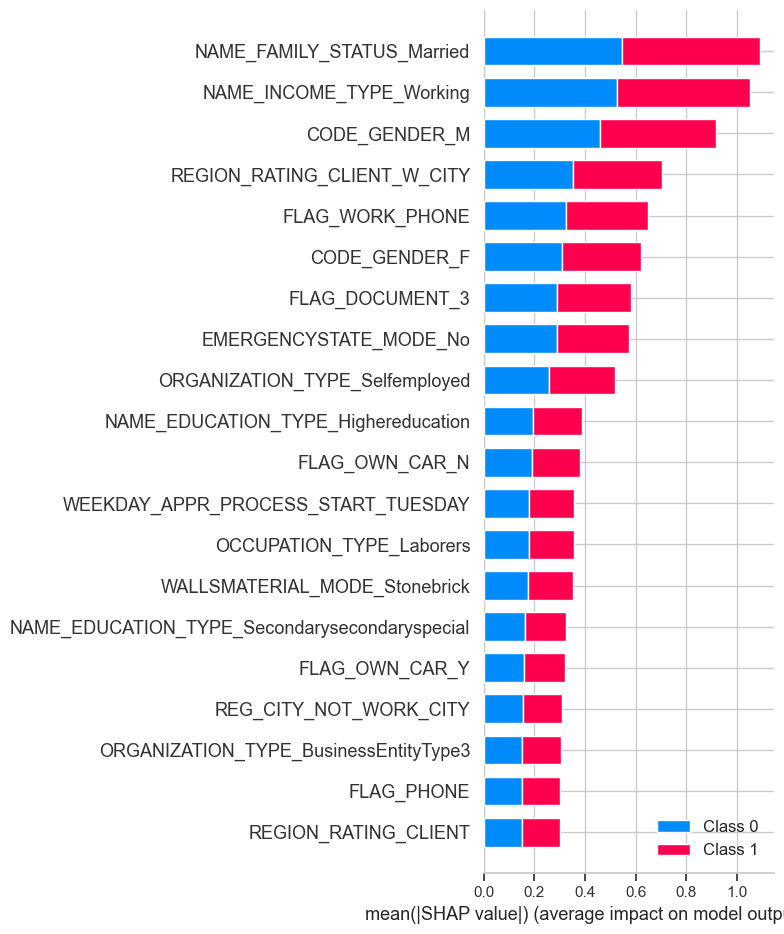

In [133]:
shap.summary_plot(shap_values, valid_x)

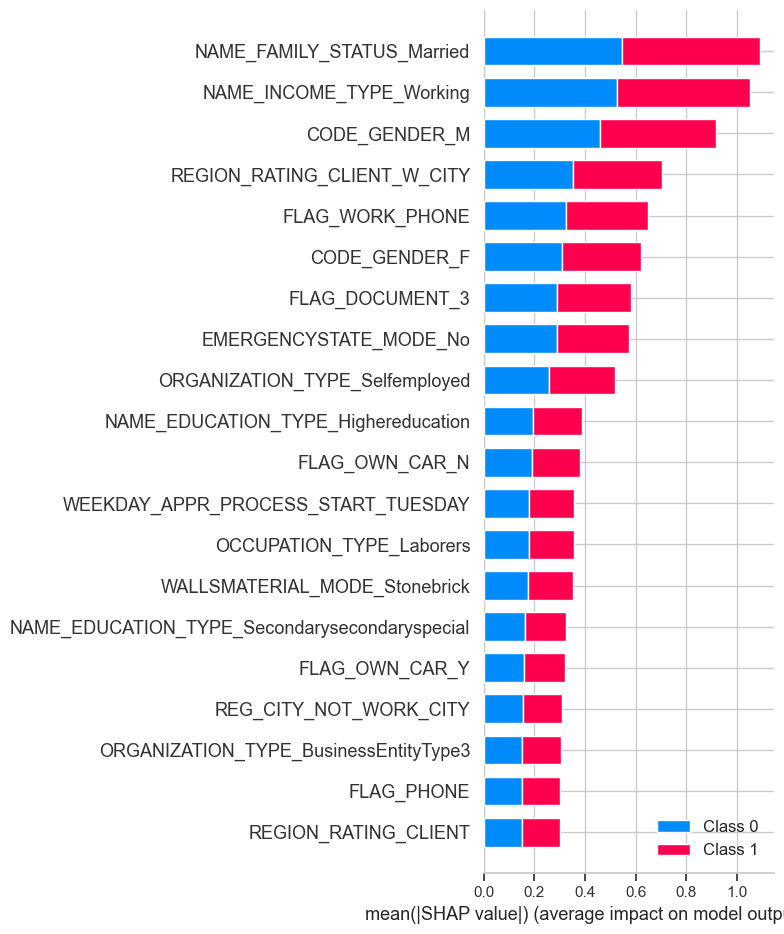

In [250]:
shap.summary_plot(shap_values, valid_x, show=False)
plt.savefig('shap_summary.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

In [247]:
plt.savefig("shap_summary.png",dpi=700)

<Figure size 640x480 with 0 Axes>

In [248]:
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

In [134]:
pickle.dump(clf, open('model.pkl','wb'))

In [190]:
shap_values[0][45]

array([ 3.06457292e-01,  5.10110493e-02,  3.70783532e-01, -6.82964153e-02,
        4.93601523e-01, -2.92662183e-02,  2.64416659e-02,  1.05367863e-01,
        0.00000000e+00,  5.10276147e-03,  0.00000000e+00,  0.00000000e+00,
        5.39100548e-05,  2.43660912e-03,  2.99866476e-02,  0.00000000e+00,
        2.11164016e-02, -5.98710819e-03, -3.74577516e-06,  0.00000000e+00,
        0.00000000e+00,  3.08633194e-01,  0.00000000e+00,  5.26577608e-02,
        5.60553617e-05,  2.82677162e-03,  5.80924083e-02, -7.68630936e-03,
        3.12569075e-01,  9.72135703e-03,  6.95425347e-03,  1.21669749e-03,
        0.00000000e+00,  5.20131541e-02,  1.83716943e-03, -1.19328410e-03,
        3.58658383e-06, -4.68543709e-02,  3.65264939e-03,  2.93282256e-04,
        2.58659419e-03,  2.27308815e-02,  5.46081118e-02,  0.00000000e+00,
        7.22696295e-03,  0.00000000e+00,  7.74040386e-02,  1.48511374e-03,
        1.52530779e-03,  6.36678108e-04, -1.84999336e-04,  0.00000000e+00,
        1.18519934e-02,  

In [205]:
type(shap_values[0][45])

numpy.ndarray

In [207]:
shap_values[0][45].shape

(368,)

In [135]:
print(shap.TreeExplainer(clf))

In [136]:
print(shap_values)

[array([[ 0.00448806,  0.01793399,  0.05045401, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00338702,  0.0171218 ,  0.02912515, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00433013,  0.01877957,  0.02341771, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.00366948,  0.01361551, -0.97867857, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00232866,  0.00971541,  0.0451455 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.01126722,  0.0055619 , -0.74212989, ...,  0.        ,
         0.        ,  0.        ]]), array([[-0.00448806, -0.01793399, -0.05045401, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00338702, -0.0171218 , -0.02912515, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00433013, -0.01877957, -0.02341771, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.00366948, -0.01361551,  0.97867857, ...,  0.        ,
        

In [137]:
#mlflow.end_run()

In [138]:
reduced_x= X_resampled.sample(frac=.001)

In [197]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(clf)
    shap_values = explainerModel.shap_values(reduced_x)
    p = shap.decision_plot(explainerModel.expected_value[0],shap_values[0][j],valid_x, ignore_warnings=True)
    return(p)

In [199]:
explainerModel=shap.TreeExplainer(clf)

In [200]:
expected_values=explainerModel.expected_value[0]

In [218]:
valid_x=pd.read_csv('valid_x.csv')

In [219]:
valid_x

NAME_CONTRACT_TYPE_Cashloans  NAME_CONTRACT_TYPE_Revolvingloans  \
0                               1.0                                0.0   
1                               1.0                                0.0   
2                               1.0                                0.0   
3                               0.0                                1.0   
4                               1.0                                0.0   
...                             ...                                ...   
90485                           1.0                                0.0   
90486                           1.0                                0.0   
90487                           1.0                                0.0   
90488                           1.0                                0.0   
90489                           1.0                                0.0   

       CODE_GENDER_F  CODE_GENDER_M  FLAG_OWN_CAR_N  FLAG_OWN_CAR_Y  \
0           1.000000       0.000000        1.000000        0.000000   
1           1.000000       0.000000        1.000000        0.000000   
2           1.000000       0.000000        1.000000        0.000000   
3           0.000000       1.000000        0.000000        1.000000   
4           1.000000       0.000000        1.000000        0.000000   
...              ...            ...             ...             ...   
90485       0.813259       0.186741        1.000000        0.000000   
90486       0.810950       0.189050        0.810950        0.189050   
90487       0.911180       0.088820        0.000000        1.000000   
90488       1.000000       0.000000        0.954937        0.045063   
90489       0.064897       0.935103        0.935103        0.064897   

       FLAG_OWN_REALTY_N  FLAG_OWN_REALTY_Y  NAME_TYPE_SUITE_Children  \
0               0.000000           1.000000                       1.0   
1               0.000000           1.000000                       0.0   
2               1.000000           0.000000                       0.0   
3               0.000000           1.000000                       0.0   
4               1.000000           0.000000                       0.0   
...                  ...                ...                       ...   
90485           0.186741           0.813259                       0.0   
90486           0.000000           1.000000                       0.0   
90487           0.000000           1.000000                       0.0   
90488           0.000000           1.000000                       0.0   
90489           0.000000           1.000000                       0.0   

       NAME_TYPE_SUITE_Family  ...  CLOSED_BUREAU_CREDIT_DEBT_RATIO_MIN  \
0                     0.00000  ...                                  0.0   
1                     0.00000  ...                                  0.0   
2                     0.00000  ...                                  0.0   
3                     0.00000  ...                                  0.0   
4                     0.00000  ...                                  0.0   
...                       ...  ...                                  ...   
90485                 0.00000  ...                                  0.0   
90486                 0.18905  ...                                  0.0   
90487                 0.00000  ...                                  0.0   
90488                 0.00000  ...                                  0.0   
90489                 0.00000  ...                                  0.0   

       CLOSED_BUREAU_CREDIT_DEBT_RATIO_MAX  \
0                                      0.0   
1                                      1.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   
...                                    ...   
90485                                  0.0   
90486                                  0.0   
90487                                  0.0   
90488                      

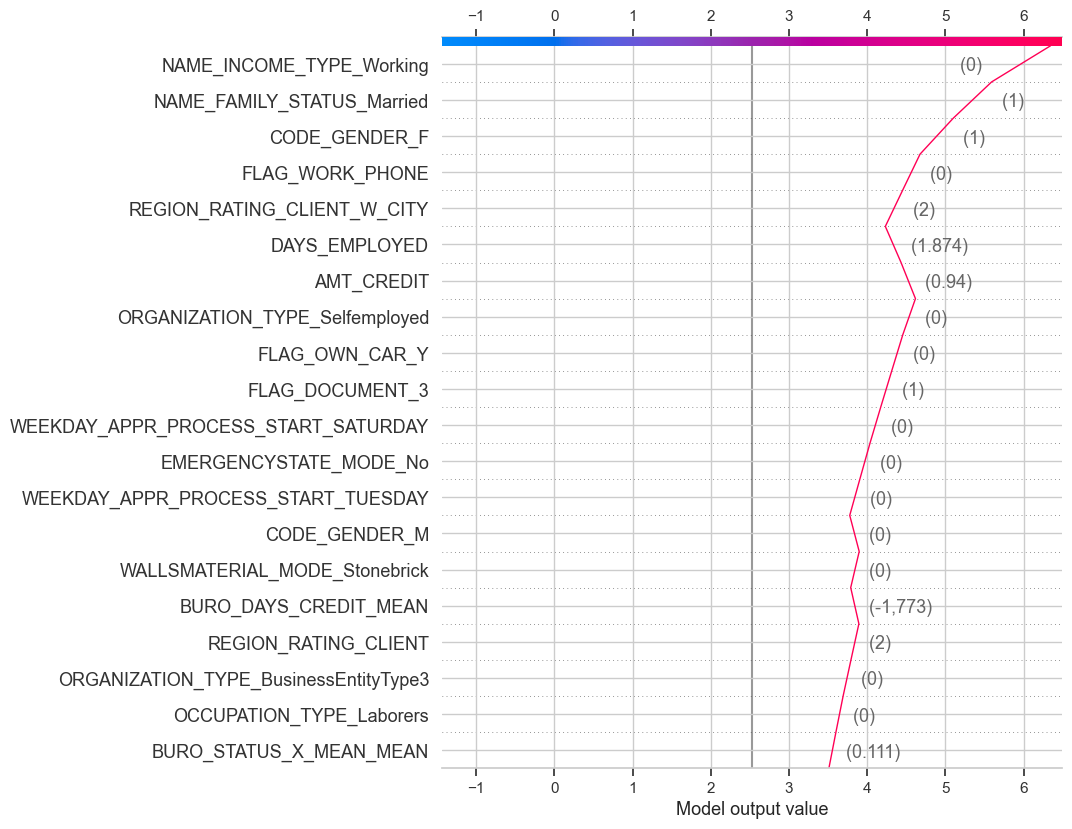

In [220]:
shap.decision_plot(w.item(),shap_values[0][12],valid_x, ignore_warnings=True)

In [235]:
from flask import jsonify, Flask
import json

In [236]:
rowshap=43

In [237]:
response_shapley = requests.post('http://localhost:6000/shap', json = rowshap)


In [240]:
response_shapley.text

'{\n  "shap_values": [\n    0.006214950265809687,\n    0.022788124378305248,\n    0.04543226887634757,\n    0.6812390437674198,\n    0.019719040108009105,\n    0.11553207487645449,\n    0.08211254437236906,\n    0.010903023754582422,\n    0.0,\n    0.0064110430157063285,\n    0.0,\n    0.0,\n    2.7216113771529847e-05,\n    -6.629123494791951e-05,\n    0.022851184074120953,\n    0.0,\n    0.08929451943575202,\n    0.09456104853412842,\n    -0.0001576992695423916,\n    0.0,\n    0.0,\n    0.7789937938679469,\n    0.0,\n    0.08165457655992868,\n    5.39153622114499e-05,\n    0.004001669752885352,\n    0.066880099817615,\n    0.007116354983356609,\n    0.41477816122995226,\n    0.011203132709417295,\n    0.0056079561770959714,\n    0.004172940721019349,\n    0.0,\n    0.07583786088773262,\n    0.004781604279611861,\n    -0.0005900811232922102,\n    1.1153817495973416e-05,\n    0.003739775217664385,\n    0.005086797739700238,\n    -0.00021232319634601843,\n    0.00151207903660085,\n    0.

In [238]:
decodedArrays = json.loads(response_shapley.text)

In [241]:
decodedArrays

{'shap_values': [0.006214950265809687,
  0.022788124378305248,
  0.04543226887634757,
  0.6812390437674198,
  0.019719040108009105,
  0.11553207487645449,
  0.08211254437236906,
  0.010903023754582422,
  0.0,
  0.0064110430157063285,
  0.0,
  0.0,
  2.7216113771529847e-05,
  -6.629123494791951e-05,
  0.022851184074120953,
  0.0,
  0.08929451943575202,
  0.09456104853412842,
  -0.0001576992695423916,
  0.0,
  0.0,
  0.7789937938679469,
  0.0,
  0.08165457655992868,
  5.39153622114499e-05,
  0.004001669752885352,
  0.066880099817615,
  0.007116354983356609,
  0.41477816122995226,
  0.011203132709417295,
  0.0056079561770959714,
  0.004172940721019349,
  0.0,
  0.07583786088773262,
  0.004781604279611861,
  -0.0005900811232922102,
  1.1153817495973416e-05,
  0.003739775217664385,
  0.005086797739700238,
  -0.00021232319634601843,
  0.00151207903660085,
  0.029416337497073623,
  0.044006478882770796,
  0.0,
  0.007875312209968444,
  0.0,
  0.14996670856619634,
  0.0015116695807326152,
  0.

In [242]:
shap_v=np.array(decodedArrays['shap_values'])
shap_v_1= np.array(shap_v, dtype=float)
shap_v_2= np.reshape(shap_v_1, (368,1))

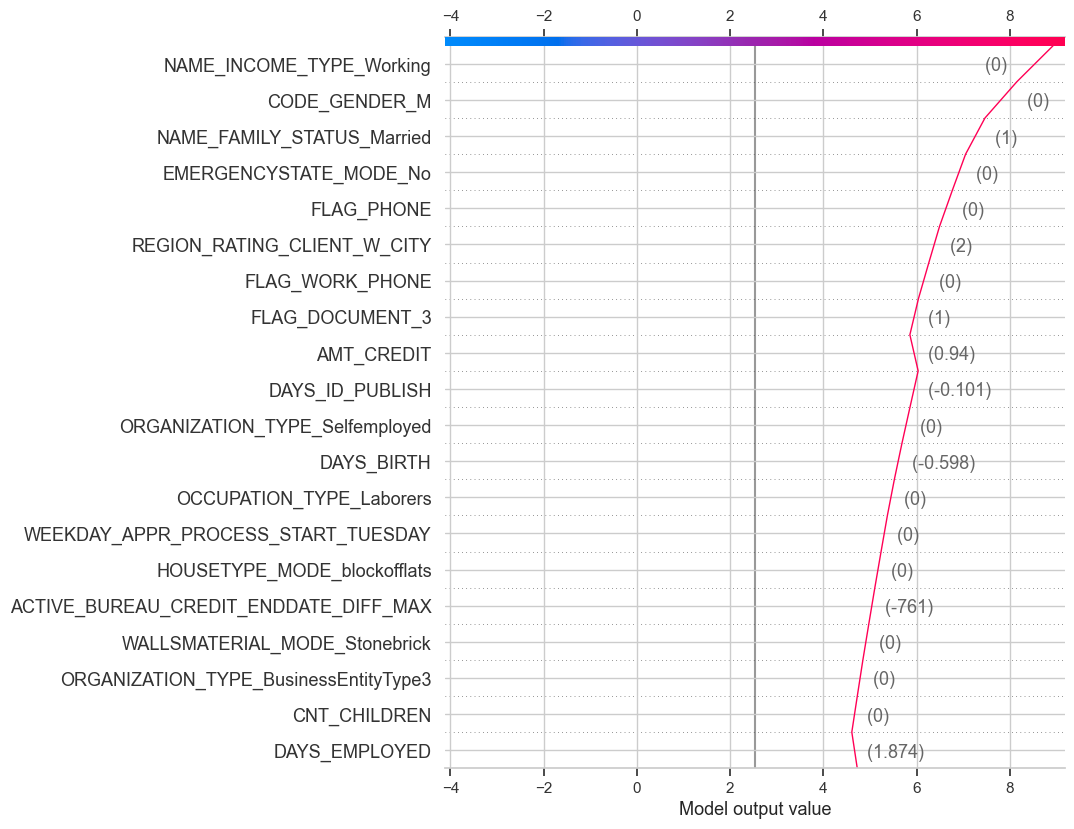

In [244]:
shap.decision_plot(w.item(),shap_v_1,valid_x, ignore_warnings=True)

In [208]:
type(expected_values)

numpy.float64

In [201]:
np.save('expected-val', expected_values)

In [209]:
w=np.load('expected-val.npy')

In [215]:
w

array(2.53273933)

In [216]:
type(w)

numpy.ndarray

In [217]:
w.item()

2.532739326571673

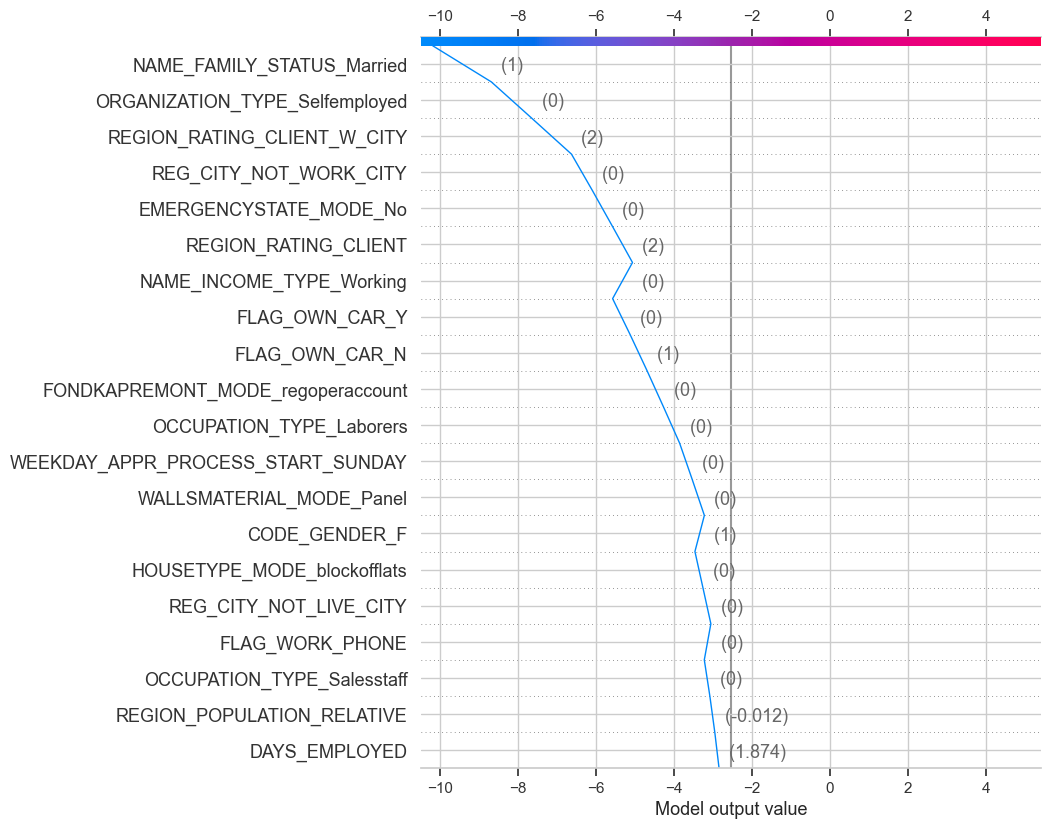

In [140]:
shap_plot(45)


In [141]:
X_resampled

NAME_CONTRACT_TYPE_Cash loans  NAME_CONTRACT_TYPE_Revolving loans  \
0                             1.00000                             0.00000   
1                             0.00000                             1.00000   
2                             1.00000                             0.00000   
3                             1.00000                             0.00000   
4                             1.00000                             0.00000   
...                               ...                                 ...   
452447                        1.00000                             0.00000   
452448                        1.00000                             0.00000   
452449                        1.00000                             0.00000   
452450                        0.66469                             0.33531   
452451                        1.00000                             0.00000   

        CODE_GENDER_F  CODE_GENDER_M  FLAG_OWN_CAR_N  FLAG_OWN_CAR_Y  \
0            0.000000       1.000000        1.000000        0.000000   
1            0.000000       1.000000        0.000000        1.000000   
2            1.000000       0.000000        1.000000        0.000000   
3            0.000000       1.000000        1.000000        0.000000   
4            0.000000       1.000000        1.000000        0.000000   
...               ...            ...             ...             ...   
452447       1.000000       0.000000        1.000000        0.000000   
452448       0.387846       0.612154        1.000000        0.000000   
452449       1.000000       0.000000        1.000000        0.000000   
452450       0.664690       0.335310        1.000000        0.000000   
452451       0.000000       1.000000        0.973089        0.026911   

        FLAG_OWN_REALTY_N  FLAG_OWN_REALTY_Y  NAME_TYPE_SUITE_Children  \
0                0.000000           1.000000                       0.0   
1                0.000000           1.000000                       0.0   
2                0.000000           1.000000                       0.0   
3                0.000000           1.000000                       0.0   
4                0.000000           1.000000                       0.0   
...                   ...                ...                       ...   
452447           0.000000           1.000000                       0.0   
452448           0.387846           0.612154                       0.0   
452449           0.000000           1.000000                       0.0   
452450           0.335310           0.664690                       0.0   
452451           0.973089           0.026911                       0.0   

        NAME_TYPE_SUITE_Family  ...  CLOSED_BUREAU_CREDIT_DEBT_RATIO_MIN  \
0                     0.000000  ...                                  0.0   
1                     0.000000  ...                                  0.0   
2                     0.000000  ...                                  0.0   
3                     0.000000  ...                                  0.0   
4                     0.000000  ...                                  0.0   
...                        ...  ...                                  ...   
452447                0.184507  ...                                  0.0   
452448                0.000000  ...                                  0.0   
452449                0.000000  ...                                  0.0   
452450                0.000000  ...                                  0.0   
452451                0.000000  ...                                  0.0   

        CLOSED_BUREAU_CREDIT_DEBT_RATIO_MAX  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   
...                                     ...   
452447                                  0.0   
452448                                  

In [142]:
X_resampled["SK_ID_CURR"]

0         100002.000000
1         100004.000000
2         100006.000000
3         100007.000000
4         100008.000000
              ...      
452447    348698.491299
452448    146385.055400
452449    217725.775175
452450    402088.383248
452451    310683.782467
Name: SK_ID_CURR, Length: 452452, dtype: float64

In [143]:
X_resampled.to_csv('X_ressampled.csv', index=False)

In [144]:
valid_x.to_csv('valid_x.csv', index=False)

In [145]:
print(X_resampled.columns)

Index(['NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Revolving loans',
       'CODE_GENDER_F', 'CODE_GENDER_M', 'FLAG_OWN_CAR_N', 'FLAG_OWN_CAR_Y',
       'FLAG_OWN_REALTY_N', 'FLAG_OWN_REALTY_Y', 'NAME_TYPE_SUITE_Children',
       'NAME_TYPE_SUITE_Family',
       ...
       'CLOSED_BUREAU_CREDIT_DEBT_RATIO_MIN',
       'CLOSED_BUREAU_CREDIT_DEBT_RATIO_MAX',
       'CLOSED_BUREAU_CREDIT_DEBT_RATIO_MEAN', 'CLOSED_DEBT_CREDIT_DIFF_MIN',
       'CLOSED_DEBT_CREDIT_DIFF_MAX', 'CLOSED_DEBT_CREDIT_DIFF_MEAN',
       'CLOSED_BUREAU_IS_DPD_MEAN', 'CLOSED_BUREAU_IS_DPD_SUM',
       'CLOSED_BUREAU_IS_DPD_OVER120_MEAN',
       'CLOSED_BUREAU_IS_DPD_OVER120_SUM'],
      dtype='object', length=368)


In [146]:
X_resampled['FLAG_OWN_CAR_N'].value_counts().idxmax()

1.0

In [147]:
most_common=[]
for i in X_resampled.columns:
    most_common.append(X_resampled[i].value_counts().idxmax())
    

In [148]:
most_common_df=pd.DataFrame(most_common).T
most_common_df.columns=X_resampled.columns
most_common_df

NAME_CONTRACT_TYPE_Cash loans  NAME_CONTRACT_TYPE_Revolving loans  \
0                            1.0                                 0.0   

   CODE_GENDER_F  CODE_GENDER_M  FLAG_OWN_CAR_N  FLAG_OWN_CAR_Y  \
0            1.0            0.0             1.0             0.0   

   FLAG_OWN_REALTY_N  FLAG_OWN_REALTY_Y  NAME_TYPE_SUITE_Children  \
0                0.0                1.0                       0.0   

   NAME_TYPE_SUITE_Family  ...  CLOSED_BUREAU_CREDIT_DEBT_RATIO_MIN  \
0                     0.0  ...                                  0.0   

   CLOSED_BUREAU_CREDIT_DEBT_RATIO_MAX  CLOSED_BUREAU_CREDIT_DEBT_RATIO_MEAN  \
0                                  0.0                                   0.0   

   CLOSED_DEBT_CREDIT_DIFF_MIN  CLOSED_DEBT_CREDIT_DIFF_MAX  \
0                      44806.5                     188082.0   

   CLOSED_DEBT_CREDIT_DIFF_MEAN  CLOSED_BUREAU_IS_DPD_MEAN  \
0                      117000.0                        0.0   

   CLOSED_BUREAU_IS_DPD_SUM  CLOSED_BUREAU_IS_DPD_OVER120_MEAN  \
0                       0.0                                0.0   

   CLOSED_BUREAU_IS_DPD_OVER120_SUM  
0                               0.0  

[1 rows x 368 columns]

In [149]:
train_preds

array([0., 0., 0., ..., 0., 0., 0.])

In [150]:
y_resampled

0         1
1         0
2         0
3         0
4         0
         ..
452447    1
452448    1
452449    1
452450    1
452451    1
Name: TARGET, Length: 452452, dtype: int64

In [151]:
train_preds_2=np.rint (train_preds)
train_preds_2

array([0., 0., 0., ..., 0., 0., 0.])

In [152]:
f1_score(train_preds_2, y_resampled)

0.3092178760513072

In [153]:
train_x["SK_ID_CURR"].to_csv('listId.csv')

In [154]:
 x=X_resampled.loc[X_resampled['SK_ID_CURR'] == 100008]

In [155]:
x

NAME_CONTRACT_TYPE_Cash loans  NAME_CONTRACT_TYPE_Revolving loans  \
4                            1.0                                 0.0   

   CODE_GENDER_F  CODE_GENDER_M  FLAG_OWN_CAR_N  FLAG_OWN_CAR_Y  \
4            0.0            1.0             1.0             0.0   

   FLAG_OWN_REALTY_N  FLAG_OWN_REALTY_Y  NAME_TYPE_SUITE_Children  \
4                0.0                1.0                       0.0   

   NAME_TYPE_SUITE_Family  ...  CLOSED_BUREAU_CREDIT_DEBT_RATIO_MIN  \
4                     0.0  ...                                  0.0   

   CLOSED_BUREAU_CREDIT_DEBT_RATIO_MAX  CLOSED_BUREAU_CREDIT_DEBT_RATIO_MEAN  \
4                                  0.0                                   0.0   

   CLOSED_DEBT_CREDIT_DIFF_MIN  CLOSED_DEBT_CREDIT_DIFF_MAX  \
4                      95134.5                     105705.0   

   CLOSED_DEBT_CREDIT_DIFF_MEAN  CLOSED_BUREAU_IS_DPD_MEAN  \
4                     100419.75                        0.0   

   CLOSED_BUREAU_IS_DPD_SUM  CLOSED_BUREAU_IS_DPD_OVER120_MEAN  \
4                       0.0                                0.0   

   CLOSED_BUREAU_IS_DPD_OVER120_SUM  
4                               0.0  

[1 rows x 368 columns]

In [156]:
try1=clf.predict_proba(x, num_iteration=clf.best_iteration_)[:, 1]
try1

array([0.0892111])

In [157]:
try1.tolist()[0]

0.08921109749799191

In [158]:
listid=pd.read_csv('listid.csv')['SK_ID_CURR']
listid

0         100002.000000
1         100004.000000
2         100006.000000
3         100007.000000
4         100008.000000
              ...      
361957    348698.491299
361958    146385.055400
361959    217725.775175
361960    402088.383248
361961    310683.782467
Name: SK_ID_CURR, Length: 361962, dtype: float64

In [159]:
type(listid)

pandas.core.series.Series